#  HR Analytics

In [2]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from sklearn import preprocessing

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import model_selection
from sklearn.feature_selection import RFE, RFECV

In [3]:
hr = pd.read_csv(r'C:\Users\Microsoft\Documents\archive (3).zip')
hr

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# Data Preparation

In [4]:
hr.shape

(14999, 10)

In [5]:
# Describe each variable

def df_desc(df):
    import pandas as pd
    desc = pd.DataFrame({'dtype': df.dtypes,
                        'NAs':df.isna().sum(),
                        'Numerical': (df.dtypes != 'object') & (df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() != len(df)),
                        'Boolean': df.apply(lambda column: column == 0).sum() + df.apply(lambda column: column == 1).sum() == len(df),
                        'Categorical': df.dtypes == 'object',
                        })
    return desc
df_desc(hr)

,dtype,NAs,Numerical,Boolean,Categorical
satisfaction_level,float64,0,True,False,False
last_evaluation,float64,0,True,False,False
number_project,int64,0,True,False,False
average_montly_hours,int64,0,True,False,False
time_spend_company,int64,0,True,False,False
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
sales,object,0,False,False,True
salary,object,0,False,False,True


In [6]:
hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [7]:
categories = {'sales':hr['sales'].unique().tolist(),
             'salary':hr['salary'].unique().tolist()}
for i in sorted(categories.keys()):
    print(i+":")
    print(categories[i])
    if i != sorted(categories.keys())[-1] :print("\n")

salary:
['low', 'medium', 'high']


sales:
['sales', 'accounting', 'hr', 'technical', 'support', 'management', 'IT', 'product_mng', 'marketing', 'RandD']


In [8]:
hr = hr.rename(index=str, columns={'sales':'department'})

# Exploratory Data Analysis

In [9]:
hr['left'].value_counts()

0    11428
1     3571
Name: left, dtype: int64

In [10]:
hr.groupby('left').mean()

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_10512\2087316466.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hr.groupby('left').mean()


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years
left,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


# Correlation Analysis

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_10512\2859091720.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hr.corr(), cmap='RdBu', annot=True)


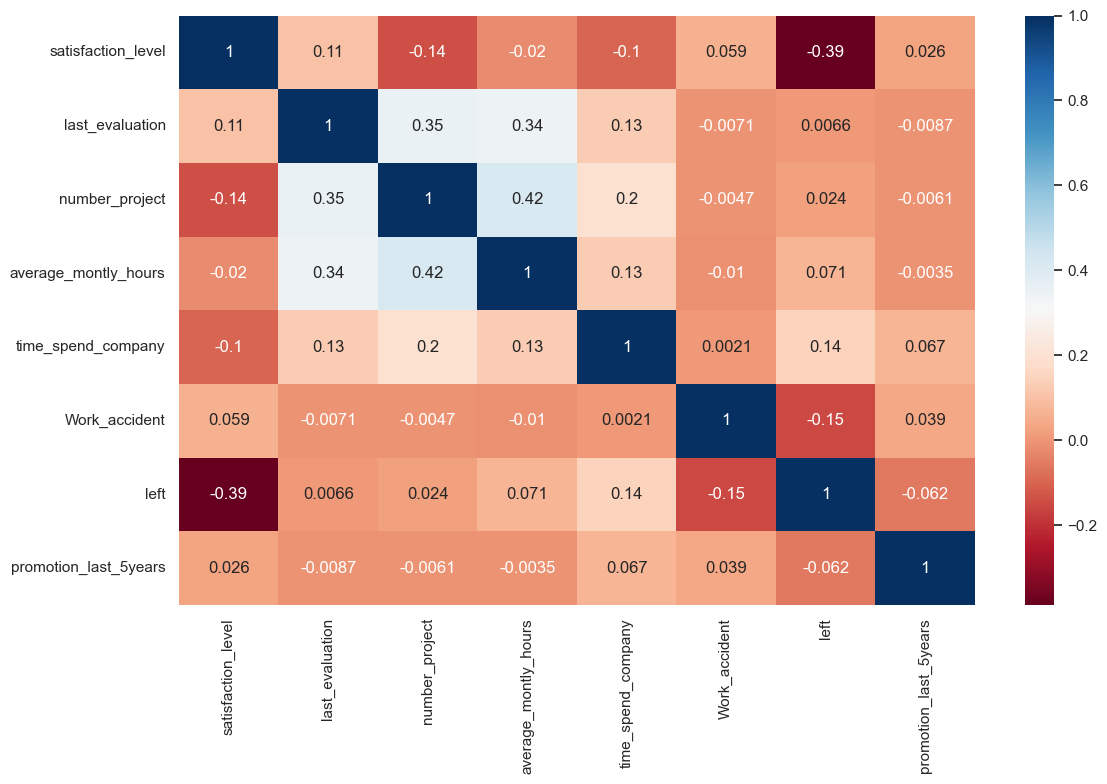

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(hr.corr(), cmap='RdBu', annot=True)
plt.tight_layout()

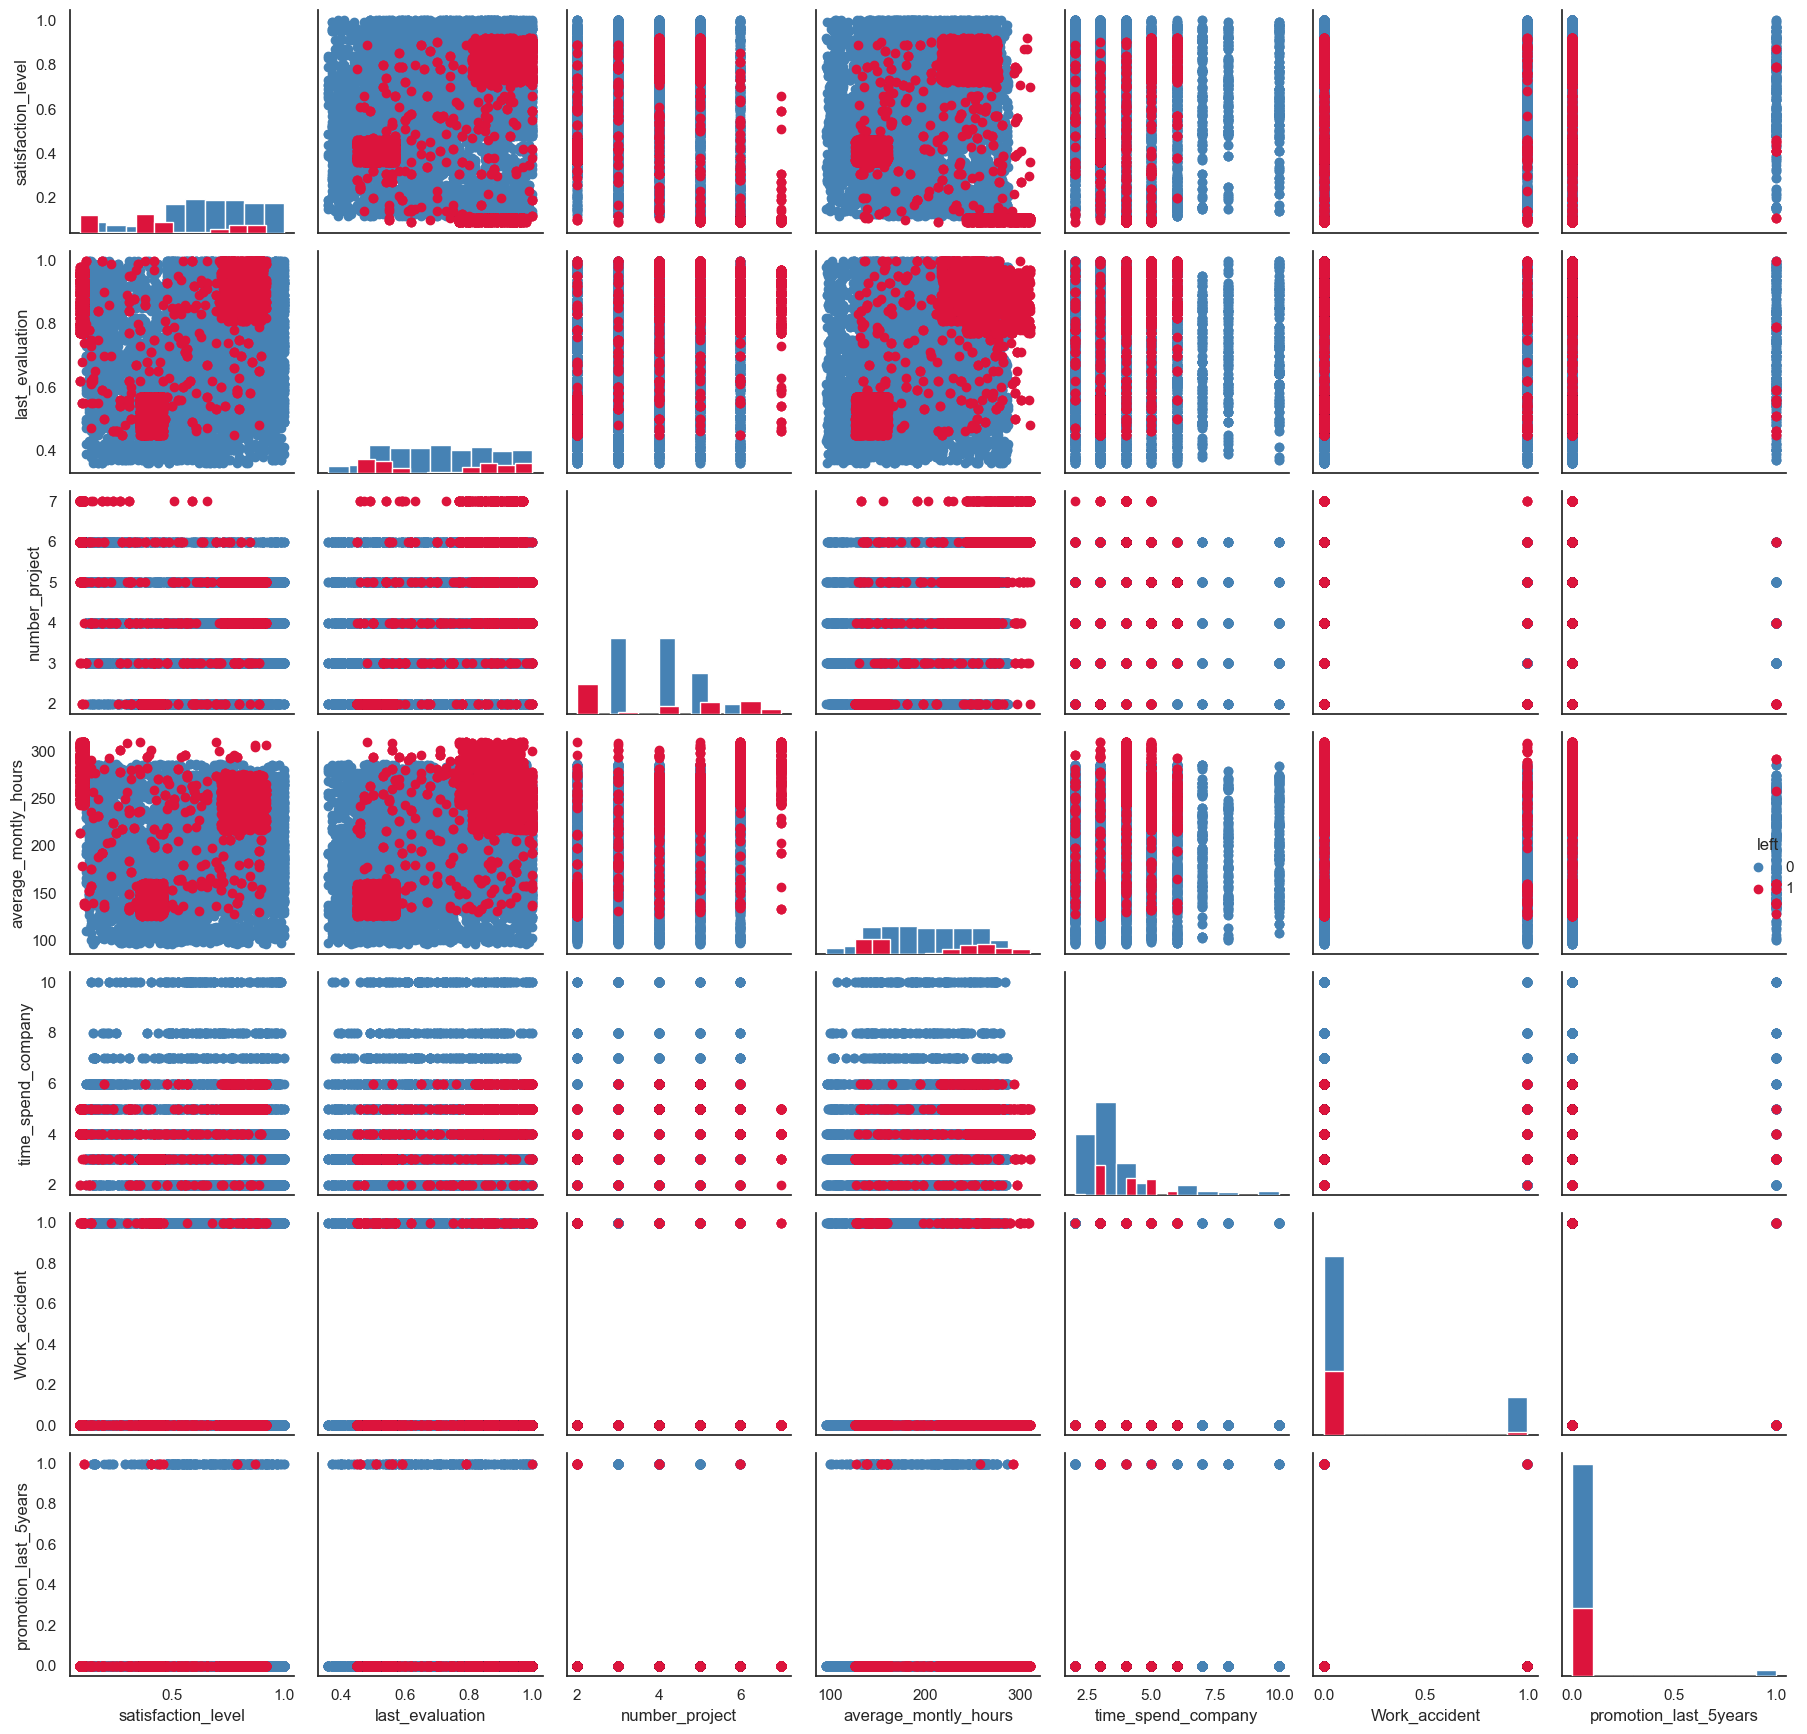

In [12]:
plot = sns.PairGrid(hr, hue='left', palette=('steelblue','crimson'))
plot = plot.map_diag(plt.hist)
plot = plot.map_offdiag(plt.scatter)
plot.add_legend()
plt.tight_layout()

# Turnover by Salary Levels

In [13]:
print('Salary levels proportions')
print(hr['salary'].value_counts()/len(hr)*100)
print('\n')
print('Turnover Rate by Salary level')
print(hr.groupby('salary')['left'].mean())

Salary levels proportions
low       48.776585
medium    42.976198
high       8.247216
Name: salary, dtype: float64


Turnover Rate by Salary level
salary
high      0.066289
low       0.296884
medium    0.204313
Name: left, dtype: float64


# Turnover by Departments

In [14]:
hr['department'].value_counts()/len(hr)*100

sales          27.601840
technical      18.134542
support        14.860991
IT              8.180545
product_mng     6.013734
marketing       5.720381
RandD           5.247016
accounting      5.113674
hr              4.926995
management      4.200280
Name: department, dtype: float64

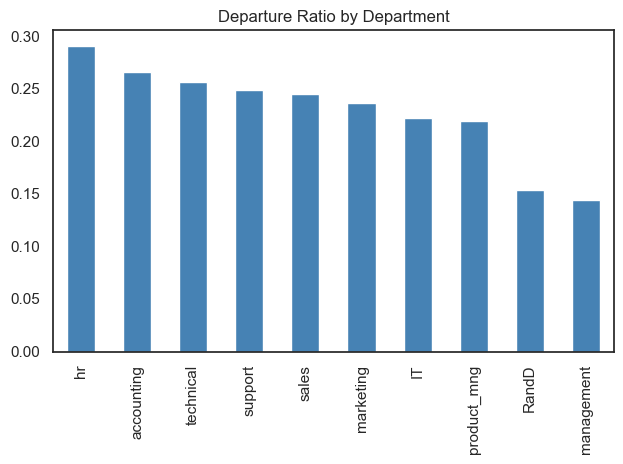

In [15]:
hr.groupby('department')['left'].mean().sort_values(ascending=False).plot(kind='bar',color='steelblue')
plt.title('Departure Ratio by Department')
plt.xlabel('')
plt.tight_layout()

# Promotion Analysis

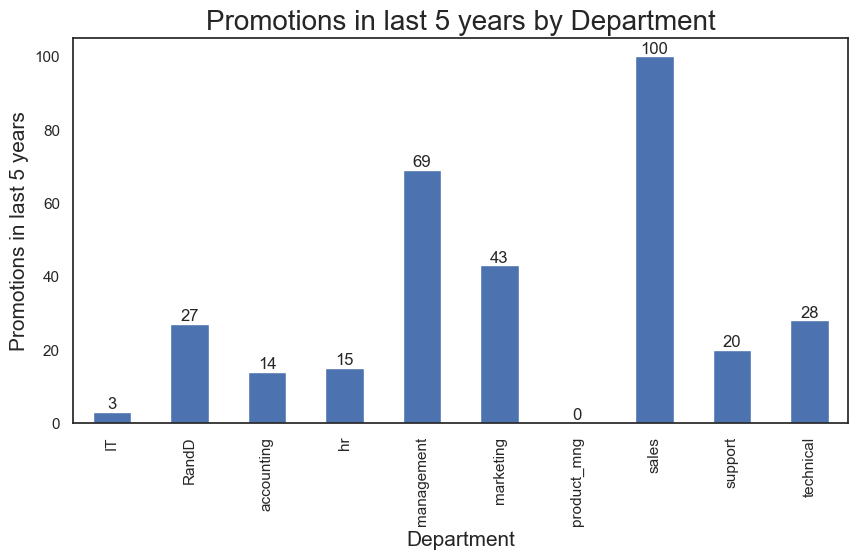

In [95]:
plt.figure(figsize=(10,5))
ax = hr.groupby('department')['promotion_last_5years'].sum().plot(kind='bar')
plt.ylabel('Promotions in last 5 years', fontsize=15)
plt.xlabel('Department', fontsize=15)
plt.title('Promotions in last 5 years by Department', fontsize=20)

# Add value labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.show()

# Turnover by Satisfaction Level

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_10512\181313236.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hr.satisfaction_level,


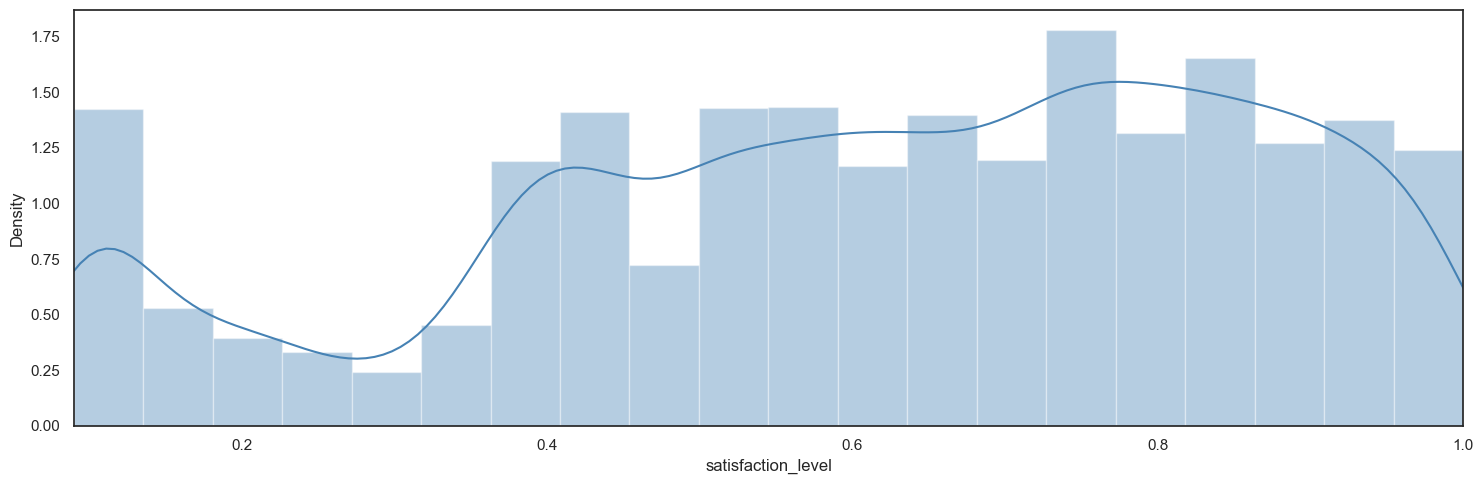

In [16]:
plt.figure(figsize=(15,5))
sns.distplot(hr.satisfaction_level,
            bins = 20,
            color = 'steelblue').axes.set_xlim(min(hr.satisfaction_level),max(hr.satisfaction_level))
plt.tight_layout()

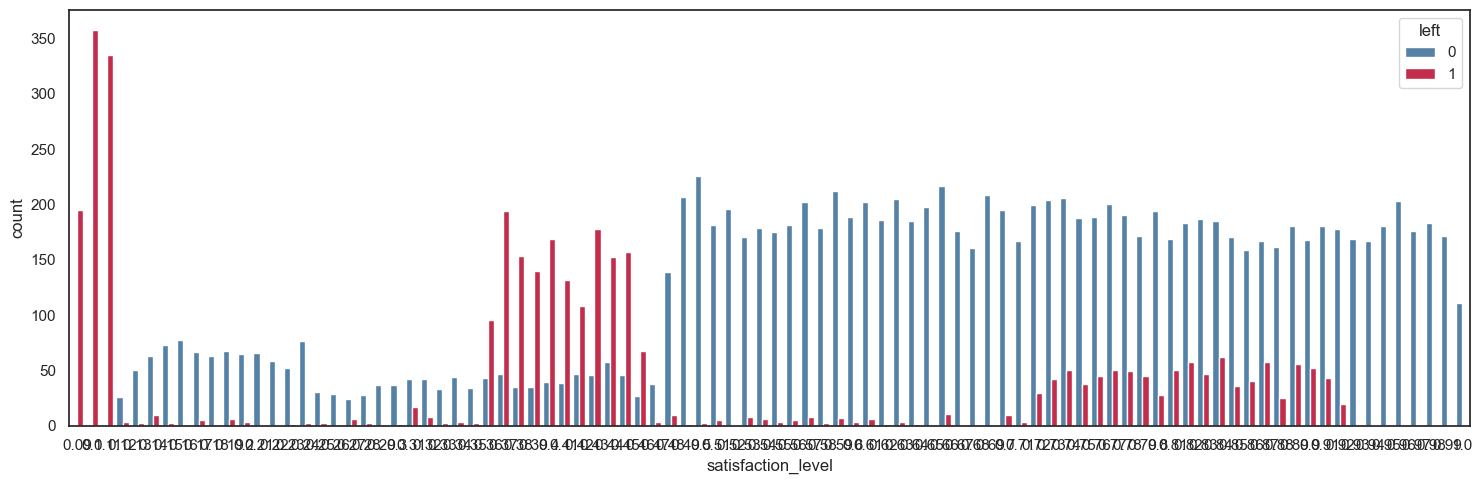

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'hr' is your DataFrame containing the data

plt.figure(figsize=(15, 5))  # Set the figure size

# Create the countplot
sns.countplot(
    x='satisfaction_level',  # X-axis: 'satisfaction_level' feature
    hue='left',  # Color by the 'left' feature (0 or 1)
    data=hr,# Your DataFrame
    palette=('steelblue', 'crimson')  # Custom color palette
)

plt.tight_layout()  # Automatically adjust subplot parameters for a tight layout
plt.show()  # Display the plot

# Turnover by Last Evaluation

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_10512\12914612.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hr.last_evaluation,


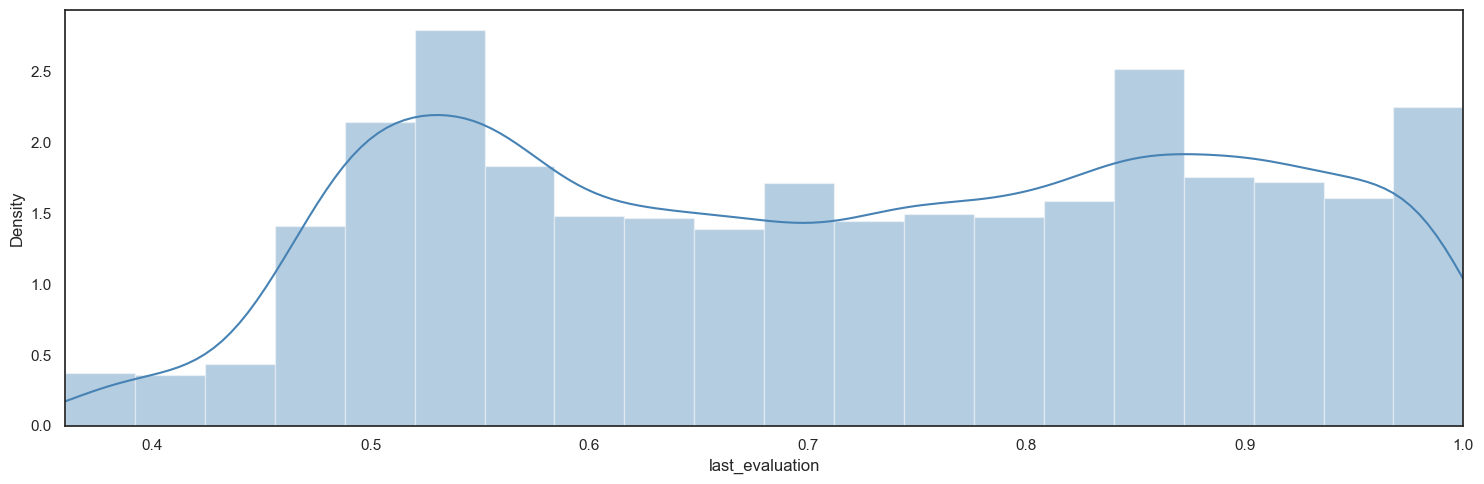

In [18]:
plt.figure(figsize=(15,5))
sns.distplot(hr.last_evaluation,
            bins = 20,
            color = 'steelblue').axes.set_xlim(min(hr.last_evaluation),max(hr.last_evaluation))
plt.tight_layout()

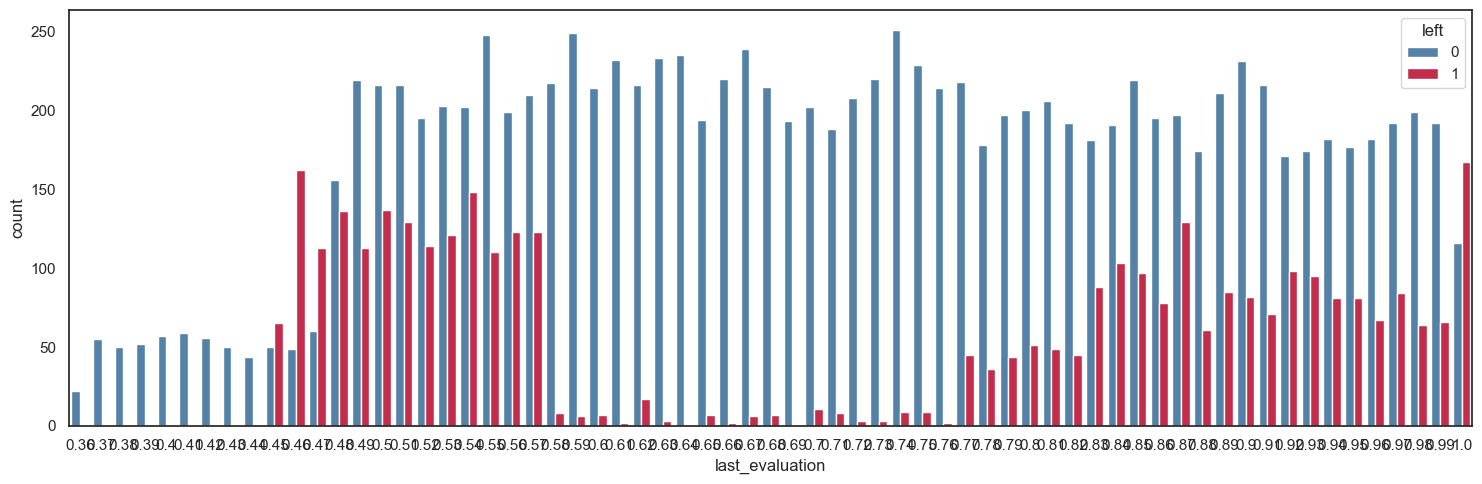

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 5))  
sns.countplot(
    x='last_evaluation',  
    hue='left',  
    data=hr,  
    palette=('steelblue', 'crimson')  
)

plt.tight_layout()  
plt.show()  

# Turnover by Number of Projects

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_10512\2657818420.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hr.number_project,


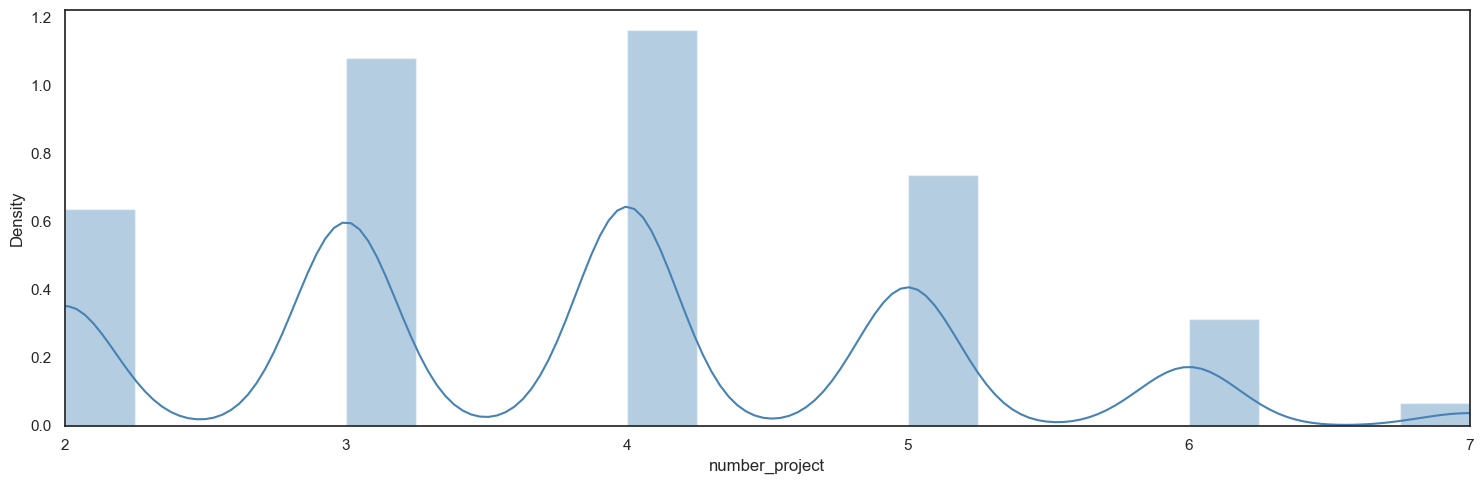

In [20]:
plt.figure(figsize=(15,5))
sns.distplot(hr.number_project,
            bins = 20,
            color = 'steelblue').axes.set_xlim(min(hr.number_project),max(hr.number_project))
plt.tight_layout()

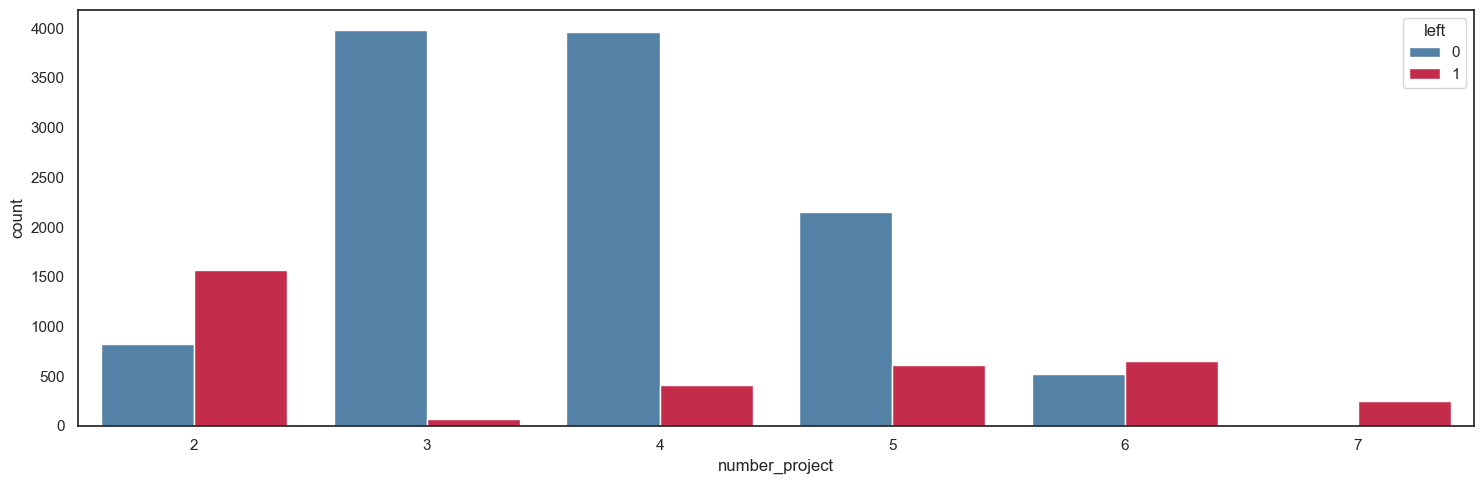

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 5))  
sns.countplot(
    x='number_project',  
    hue='left',  
    data=hr,  
    palette=('steelblue', 'crimson')  
)

plt.tight_layout()  
plt.show()  

# Turnover by Average Monthly Hours

C:\Users\Microsoft\AppData\Local\Temp\ipykernel_10512\3881273821.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(hr.average_montly_hours,


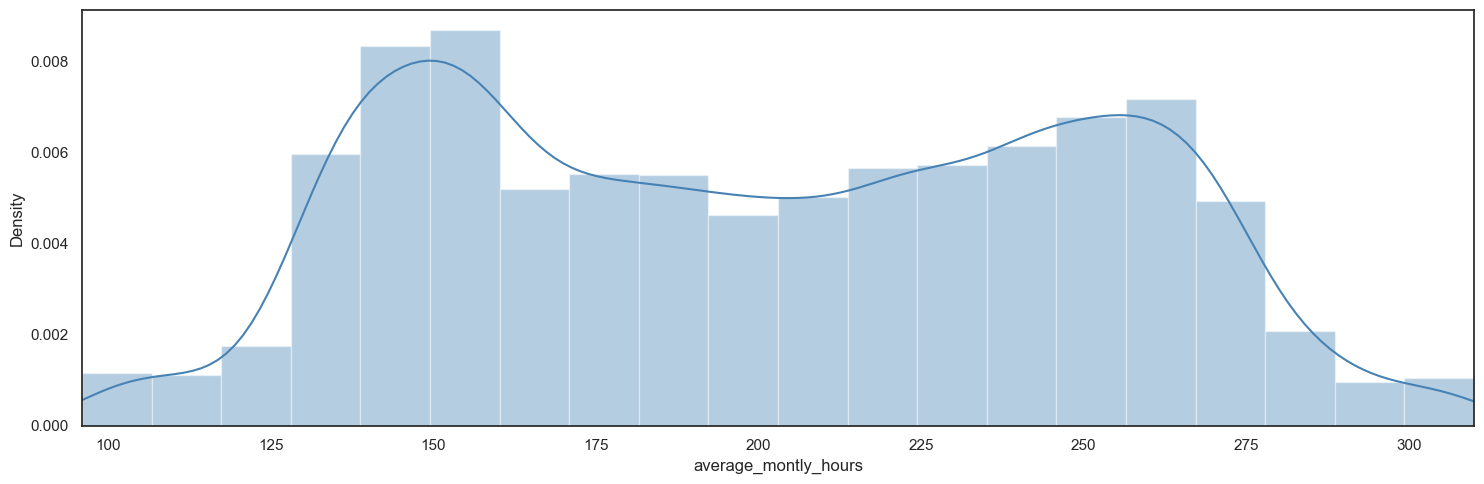

In [22]:
plt.figure(figsize=(15,5))
sns.distplot(hr.average_montly_hours,
            bins = 20,
            color = 'steelblue').axes.set_xlim(min(hr.average_montly_hours),max(hr.average_montly_hours))
plt.tight_layout()

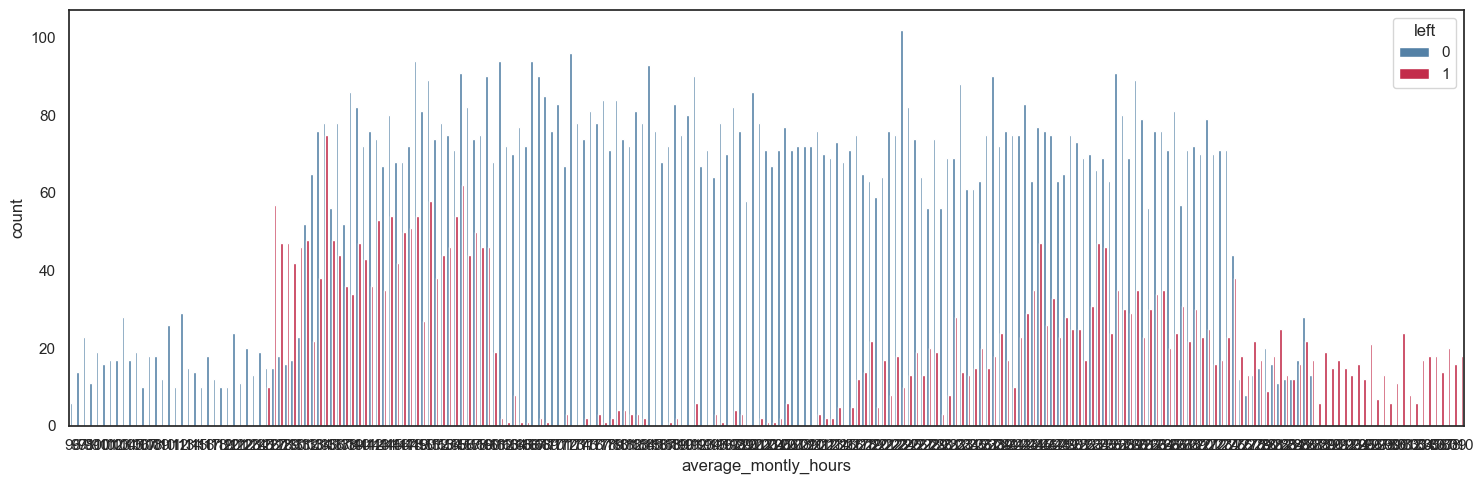

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 5))  
sns.countplot(
    x='average_montly_hours',  
    hue='left', 
    data=hr,
    palette=('steelblue', 'crimson')
)

plt.tight_layout()  
plt.show()  

# Turnover by Time Spent in the Company

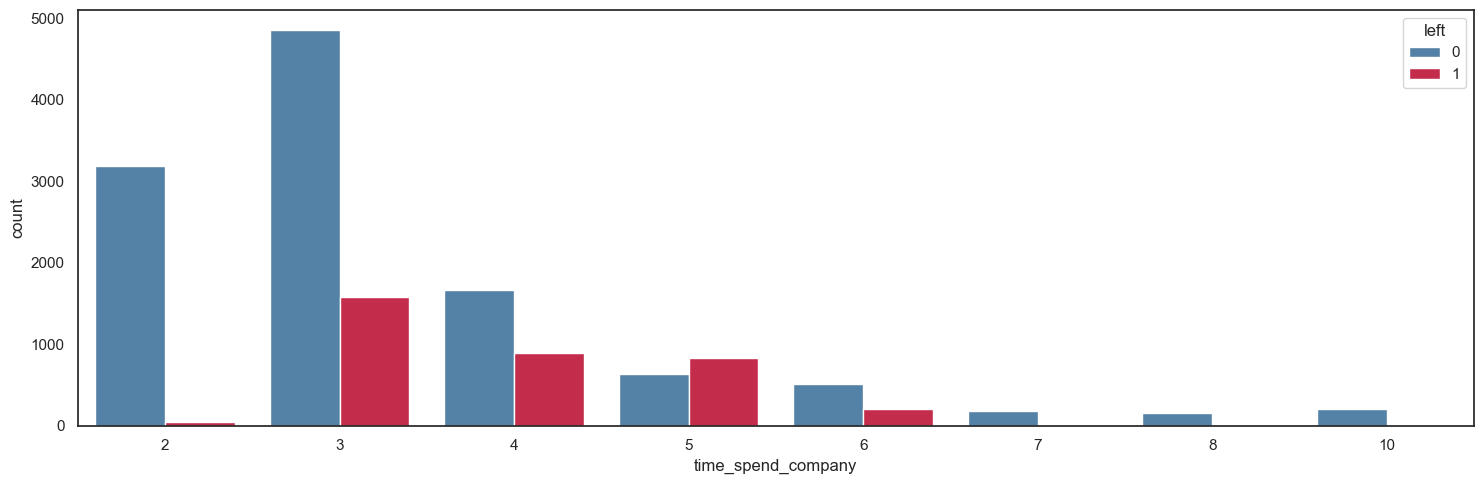

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 5)) 
sns.countplot(
    x='time_spend_company',  
    hue='left', 
    data=hr,  
    palette=('steelblue', 'crimson'))

plt.tight_layout()  
plt.show()  

# Turnover by Promotion within the past 5 years

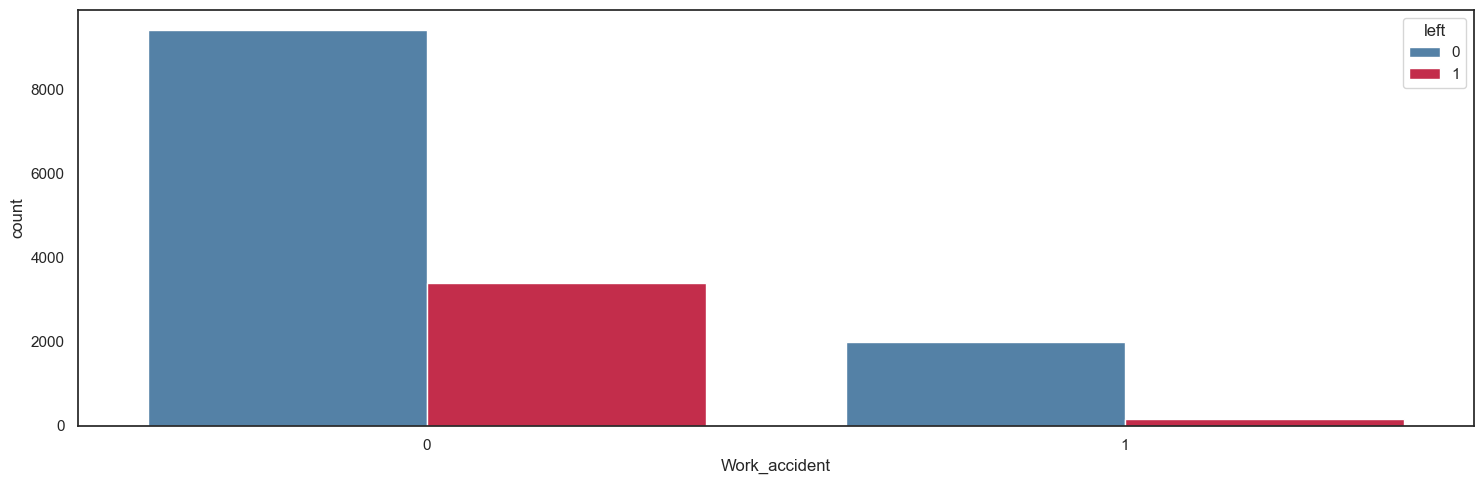

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(15, 5))  
sns.countplot(
    x='Work_accident',  
    hue='left',  
    data=hr,  
    palette=('steelblue', 'crimson')  
)

plt.tight_layout()  
plt.show()  

# Number of Projects vs Average Monthly Hours

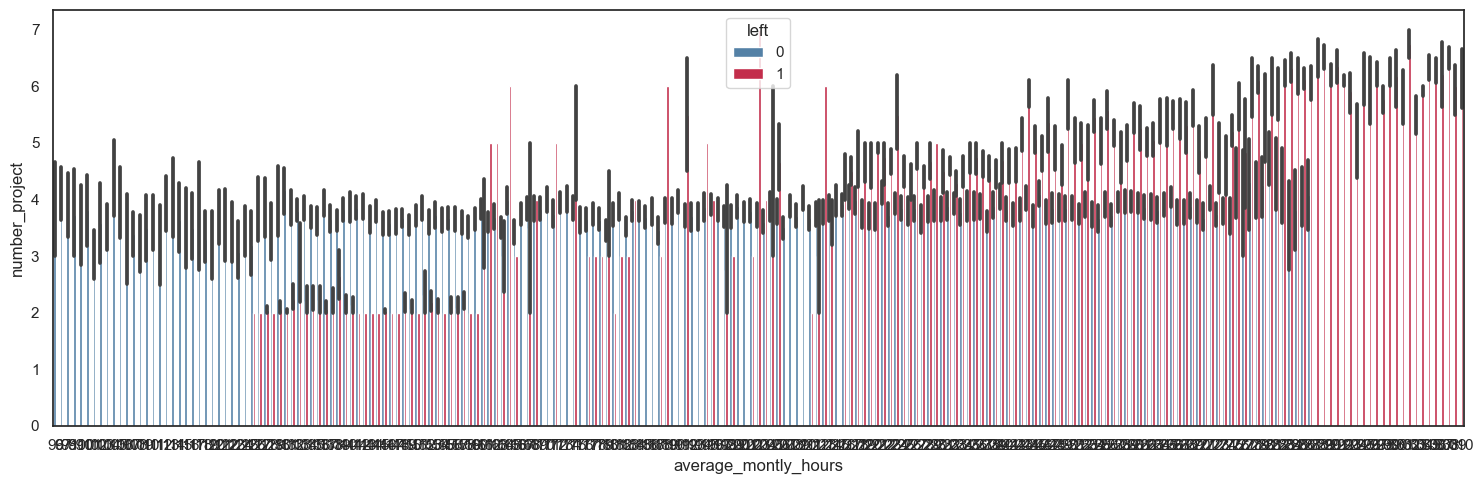

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(15, 5))  


sns.barplot(
    x=hr.average_montly_hours,
    y=hr.number_project, 
    
    hue='left',
    data=hr,  
    palette=('steelblue', 'crimson')  
)

plt.tight_layout()  
plt.show()   

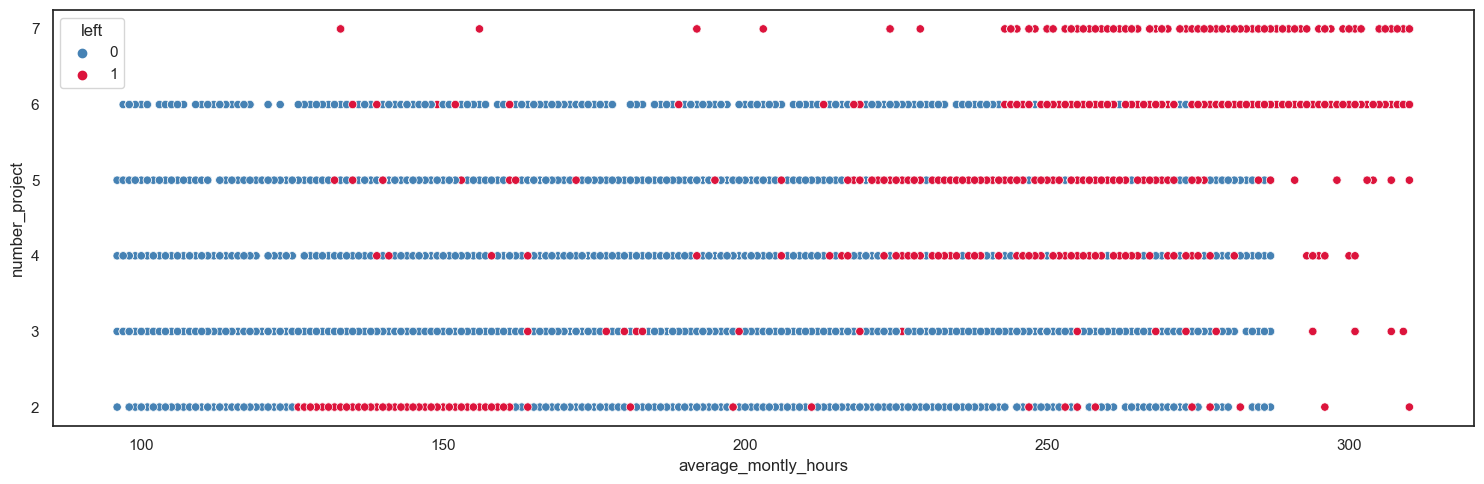

In [26]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.average_montly_hours,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

# Number of Projects vs Last Evaluation

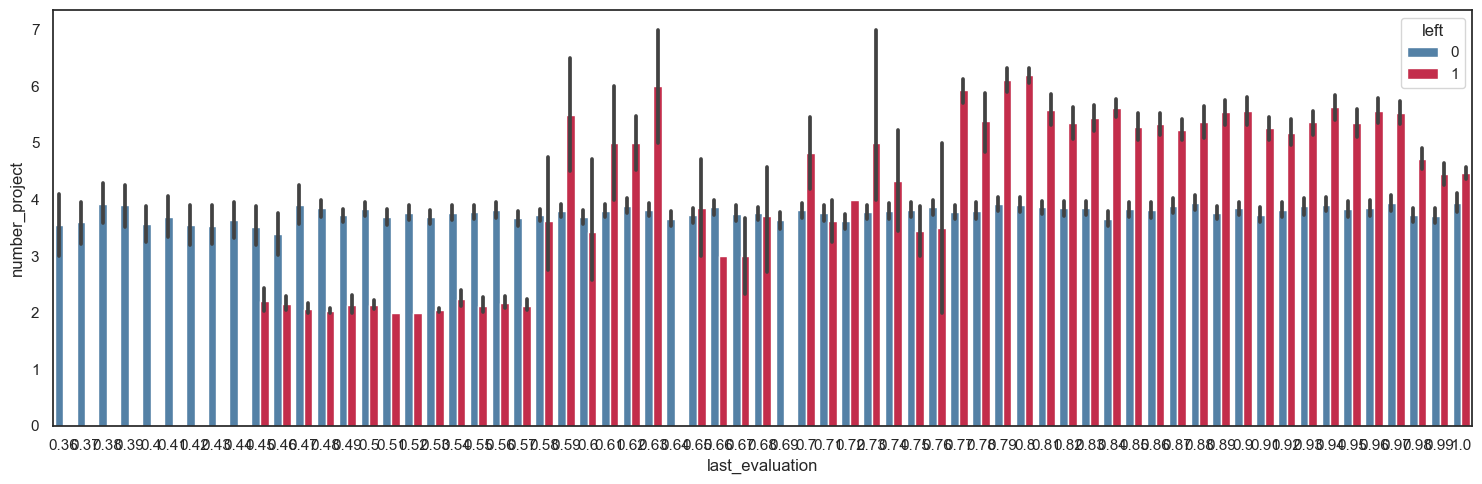

In [27]:
# Bar Plot with left values
plt.figure(figsize=(15,5))
sns.barplot(x=hr.last_evaluation,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

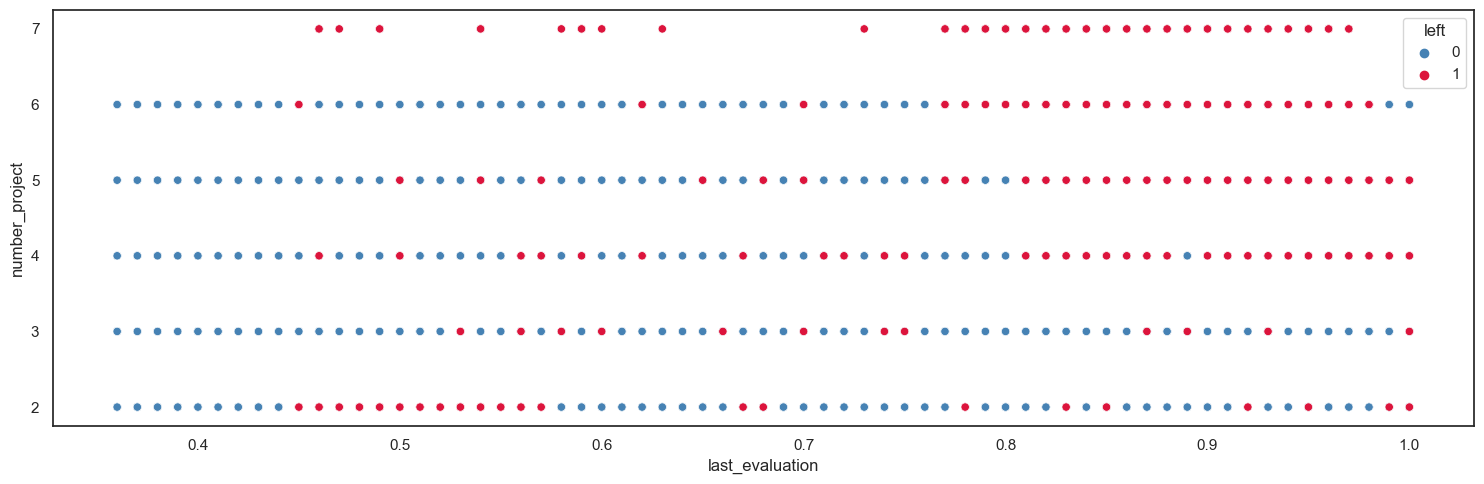

In [28]:
# Scatter Plot with left values
plt.figure(figsize=(15,5))
sns.scatterplot(x=hr.last_evaluation,
            y=hr.number_project,
            hue=hr.left,
            palette = ('steelblue', 'crimson'))
plt.tight_layout()

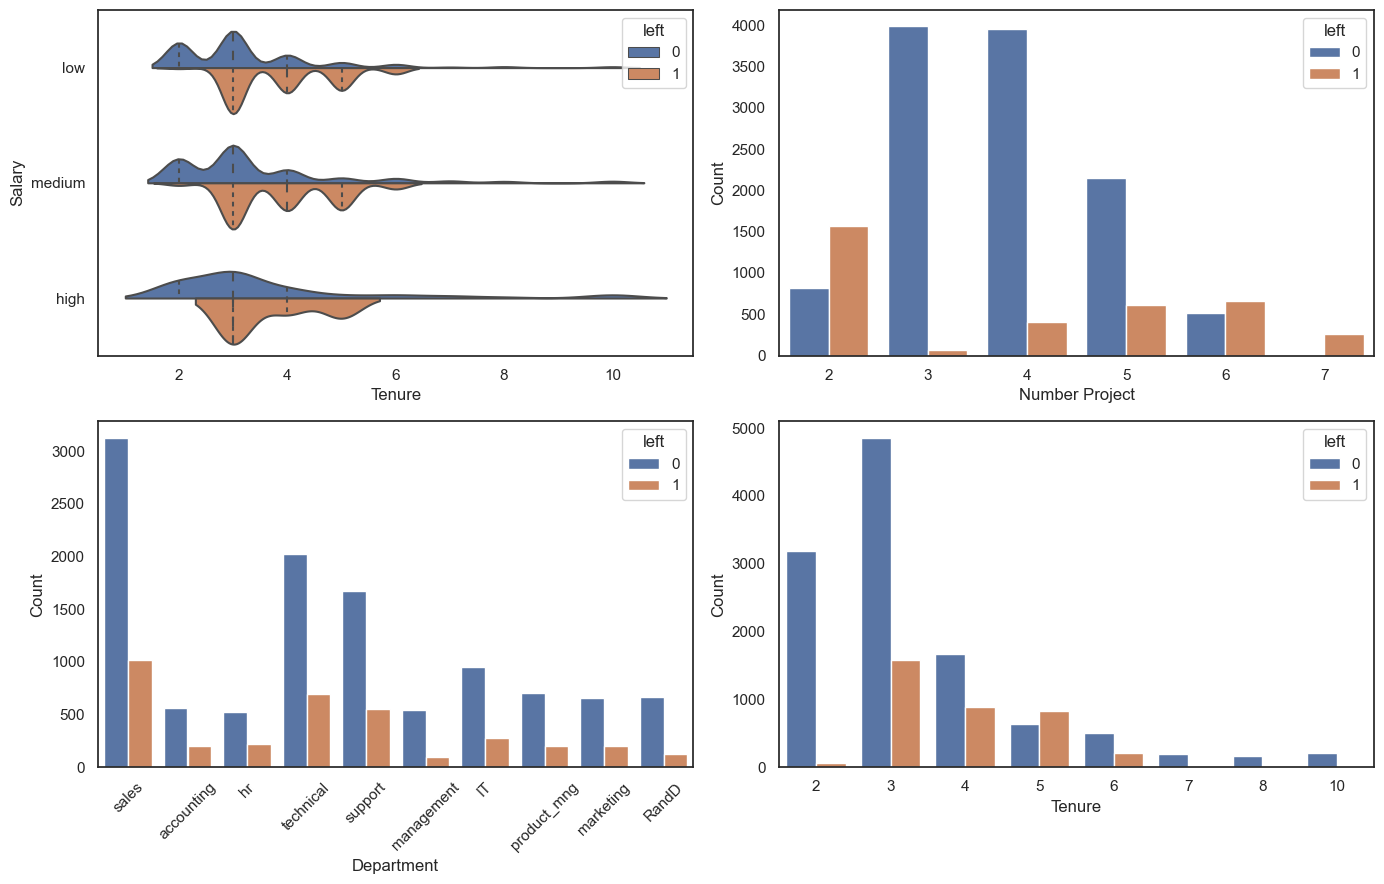

In [29]:
# Categoric Visual Description using violin and barplot
fig, axes = plt.subplots(2,2,figsize=(14,9))

sns.violinplot(data=hr, y='salary', x='time_spend_company', hue='left', split=True, inner="quart", ax=axes[0,0])
axes[0,0].set_xlabel('Tenure')
axes[0,0].set_ylabel('Salary')

sns.countplot(data=hr,x='number_project',hue='left', ax=axes[0,1])
axes[0,1].set_xlabel('Number Project')
axes[0,1].set_ylabel('Count')

sns.countplot(data=hr,x='department',hue='left', ax=axes[1,0])
axes[1,0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
axes[1,0].set_xlabel('Department')
axes[1,0].set_ylabel('Count')

sns.countplot(data=hr,x='time_spend_company',hue='left',ax=axes[1,1])
axes[1,1].set_xlabel('Tenure')
axes[1,1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Evaluation')

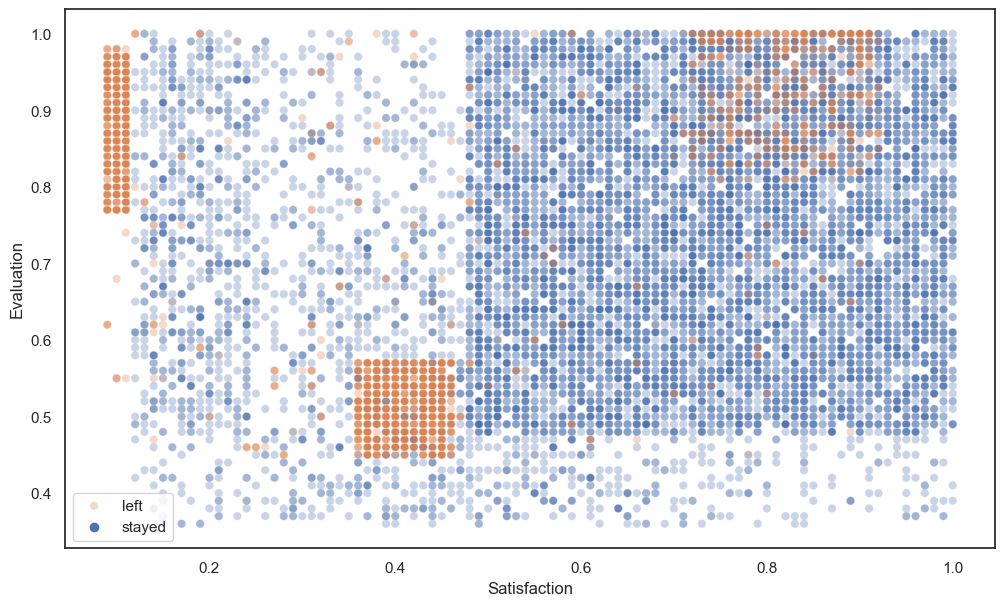

In [30]:
# Scatterplot for correlation and evaluation to left variable
plt.figure(figsize=(12,7))
sns.scatterplot(data=hr, x='satisfaction_level', y='last_evaluation', hue='left', alpha=0.3)
plt.legend(labels=['left', 'stayed'])
plt.xlabel('Satisfaction')
plt.ylabel('Evaluation')

# Encoding Categorical variables

In [31]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df


In [32]:
hr_encoded = onehot_encode(hr)
hr_encoded.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [33]:
df_desc(hr_encoded)

,dtype,NAs,Numerical,Boolean,Categorical
satisfaction_level,float64,0,True,False,False
last_evaluation,float64,0,True,False,False
number_project,int64,0,True,False,False
average_montly_hours,int64,0,True,False,False
time_spend_company,int64,0,True,False,False
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
salary_high,uint8,0,False,True,False
salary_low,uint8,0,False,True,False


# Scaling and skewness

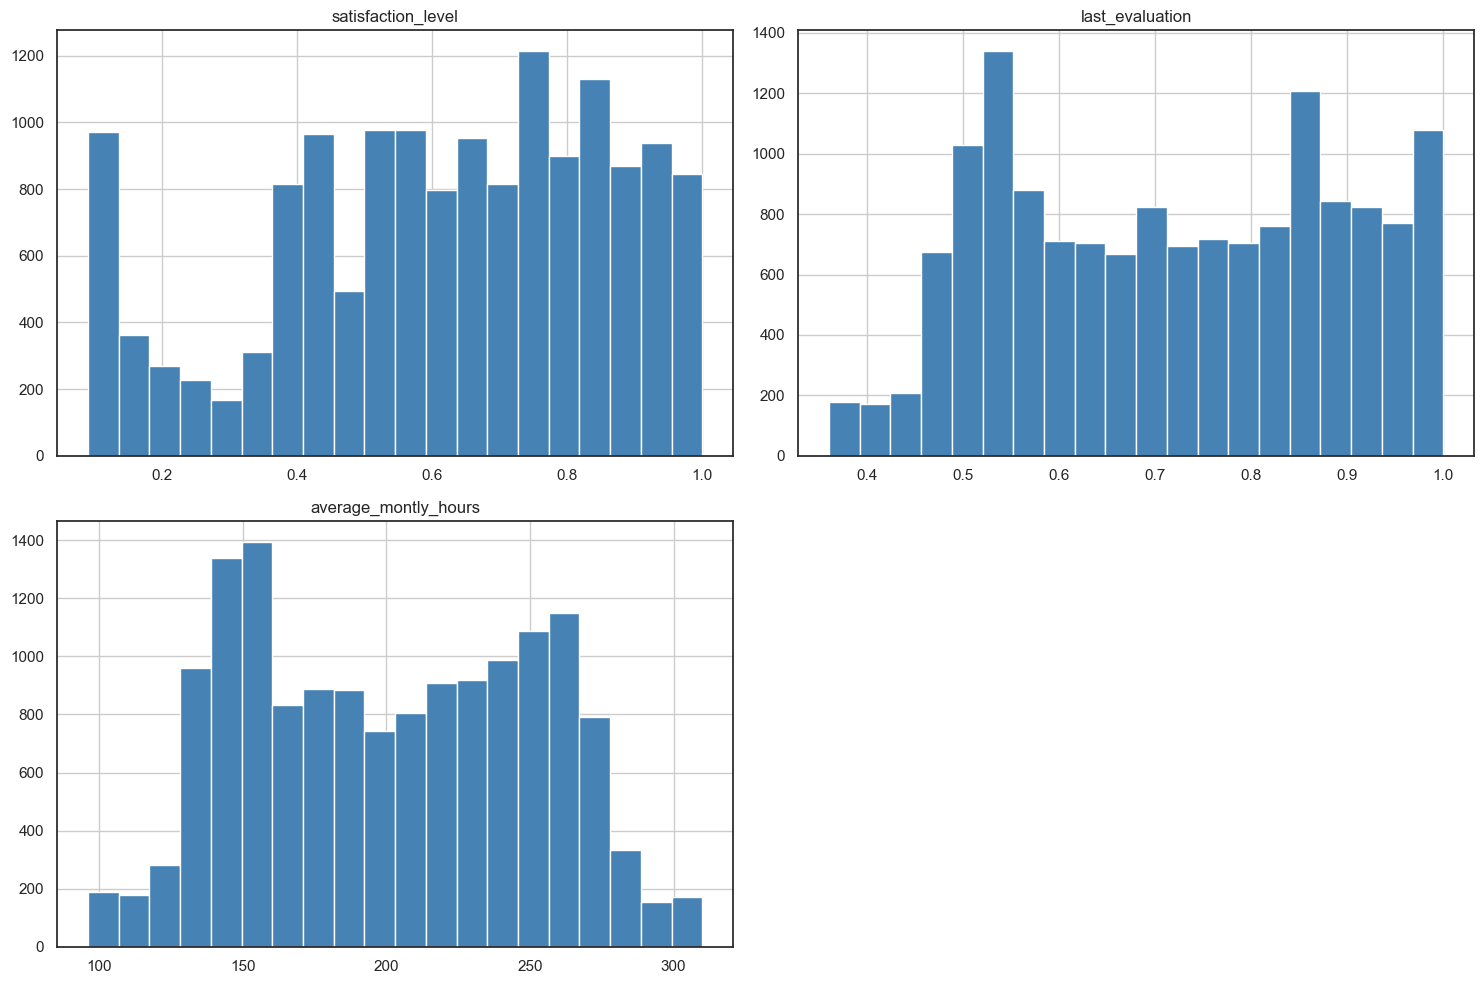

In [34]:
hr_encoded[['satisfaction_level',
           'last_evaluation',
           'average_montly_hours'
           ]].hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()


In [35]:
hr_encoded[['satisfaction_level',
           'last_evaluation',
           'average_montly_hours'
           ]].describe()

,satisfaction_level,last_evaluation,average_montly_hours
count,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,201.050337
std,0.248631,0.171169,49.943099
min,0.090000,0.360000,96.000000
25%,0.440000,0.560000,156.000000
50%,0.640000,0.720000,200.000000
75%,0.820000,0.870000,245.000000
max,1.000000,1.000000,310.000000


In [36]:
scaler = preprocessing.MinMaxScaler()
hr_scaled_part = scaler.fit_transform(hr_encoded[['satisfaction_level',
                                                  'last_evaluation',
                                                  'average_montly_hours']])
hr_scaled_part = pd.DataFrame(hr_scaled_part, columns=list(['satisfaction_level',
                                                  'last_evaluation',
                                                  'average_montly_hours']))

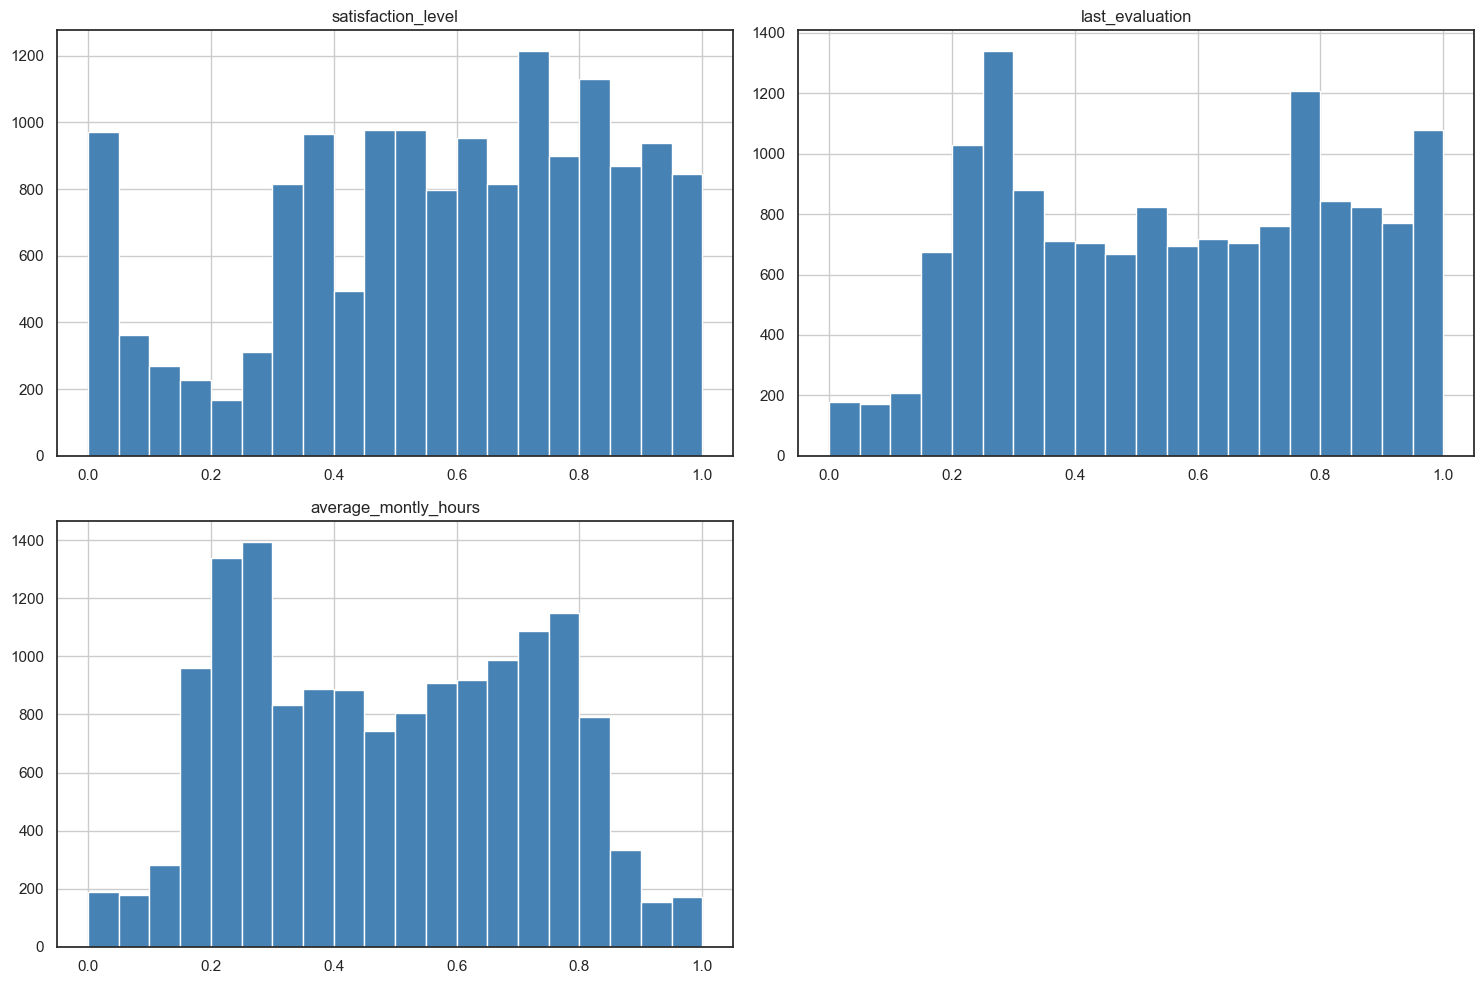

In [37]:
hr_scaled_part[['satisfaction_level',
                'last_evaluation',
                'average_montly_hours']].hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [38]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

In [39]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df
hr_skewed_part = fix_skewness(hr_scaled_part)

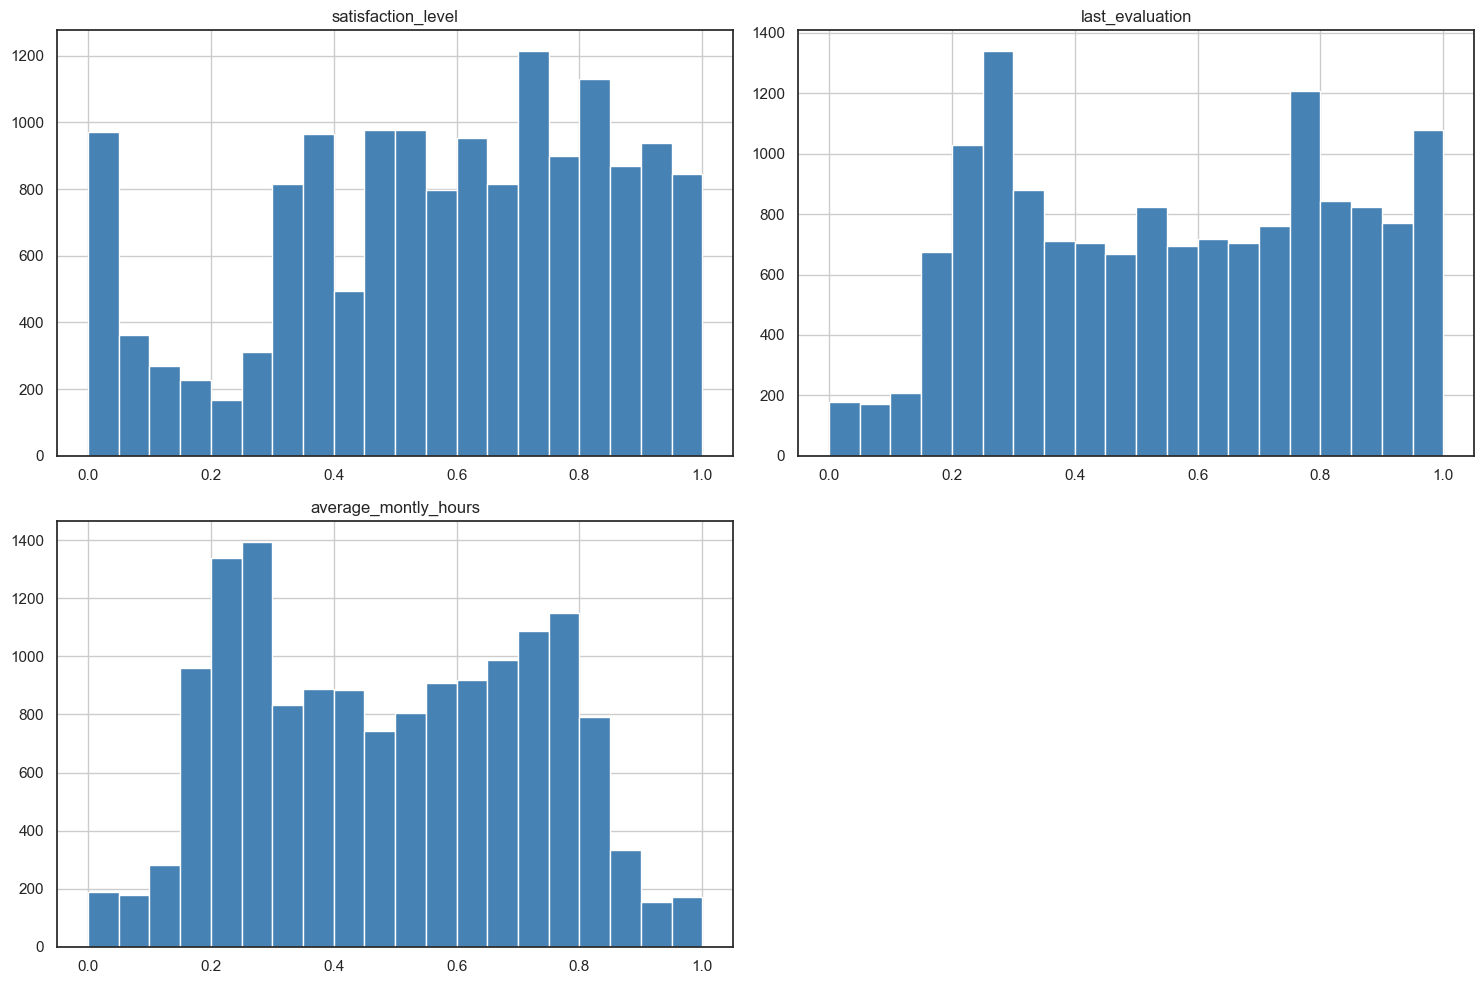

In [40]:
hr_skewed_part.hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

In [41]:
hr_simple = hr_encoded.copy()
hr_simple.drop(['satisfaction_level',
                'last_evaluation',
                'average_montly_hours'], inplace=True, axis=1)

hr_ready = pd.DataFrame()
hr_simple.reset_index(drop=True, inplace=True)
hr_skewed_part.reset_index(drop=True, inplace=True)

hr_ready = pd.concat([hr_skewed_part,hr_simple], axis=1, sort=False, ignore_index=False)

# hr_ready['number_project'] = hr_ready['number_project'].astype('category').cat.codes
# hr_ready['time_spend_company'] = hr_ready['time_spend_company'].astype('category').cat.codes

hr_ready.head()

,satisfaction_level,last_evaluation,average_montly_hours,number_project,time_spend_company,Work_accident,left,promotion_last_5years,salary_high,salary_low,...,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.318681,0.265625,0.285047,2,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0.780220,0.781250,0.775701,5,6,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.021978,0.812500,0.822430,7,4,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.692308,0.796875,0.593458,5,5,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.307692,0.250000,0.294393,2,3,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [42]:
df_desc(hr_ready)

,dtype,NAs,Numerical,Boolean,Categorical
satisfaction_level,float64,0,True,False,False
last_evaluation,float64,0,True,False,False
average_montly_hours,float64,0,True,False,False
number_project,int64,0,True,False,False
time_spend_company,int64,0,True,False,False
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
salary_high,uint8,0,False,True,False
salary_low,uint8,0,False,True,False


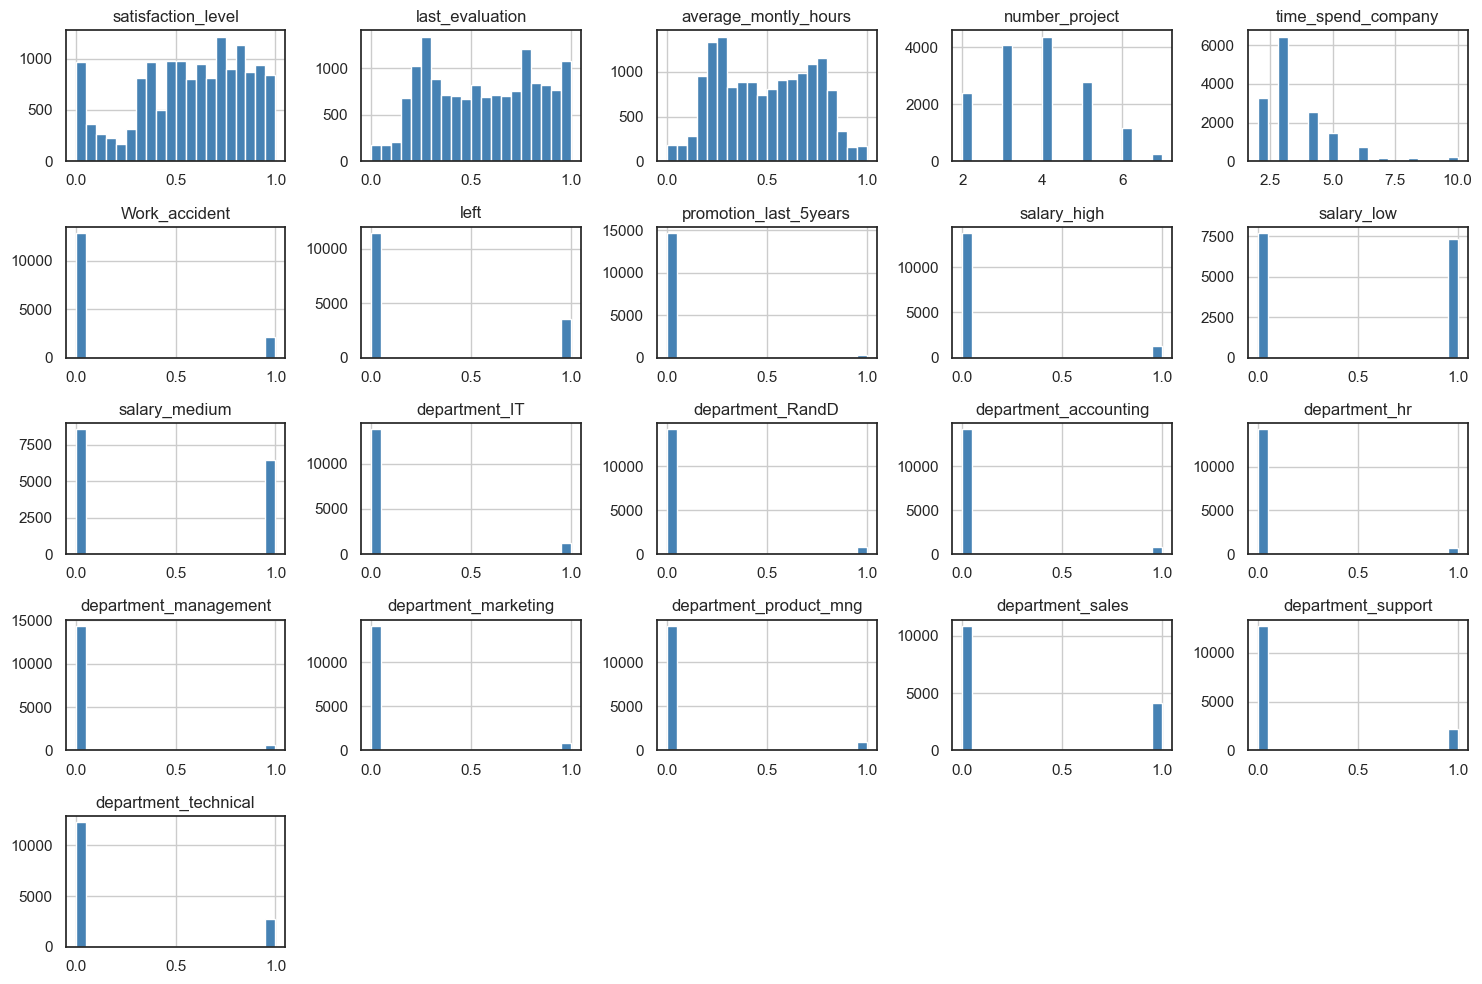

In [43]:
hr_ready.hist(bins = 20, figsize = (15,10), color = 'steelblue')
plt.tight_layout()

# Training/Test Split

In [44]:
target = 'left'

split_ratio = 0.3
seed = 806

def split_dataset(df, target, split_ratio=0.3, seed=806):
    features = list(df)
    features.remove(target)
    
    X = df[features]
    y = df[[target]]
     
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_ratio, random_state=seed)
    
    return X, y, X_train, X_test, y_train, y_test

X, y, X_train, X_test, y_train, y_test = split_dataset(hr_ready, target, split_ratio, seed)

print('Features:',X.shape[0], 'items | ', X.shape[1],'columns')
print('Target:',y.shape[0], 'items | ', y.shape[1],'columns')
print('Features Train:',X_train.shape[0],'items | ', X_train.shape[1],'columns')
print('Features Test:',X_test.shape[0],'items | ',X_test.shape[1],'columns')
print('Target Train:',y_train.shape[0],'items | ',y_train.shape[1],'columns')
print('Target Test:',y_test.shape[0],'items | ',y_train.shape[1],'columns')

Features: 14999 items |  20 columns
Target: 14999 items |  1 columns
Features Train: 10499 items |  20 columns
Features Test: 4500 items |  20 columns
Target Train: 10499 items |  1 columns
Target Test: 4500 items |  1 columns


# Baseline

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create a logistic regression model with specific parameters
lr = LogisticRegression(solver='lbfgs', max_iter=300)

# Define a function to train and evaluate the model
def lr_run(model, X_train, y_train, X_test, y_test):
    result = model.fit(X_train, y_train.values.ravel())

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy on the test set
    acc_test = model.score(X_test, y_test)

    # Get the coefficients of the model and print them
    coefficients = pd.concat([
        pd.DataFrame(X_train.columns, columns=['Feature']),
        pd.DataFrame(np.transpose(model.coef_), columns=['Coef.'])
    ], axis=1)
    coefficients.loc[-1] = ['intercept.', model.intercept_[0]]
    coefficients.index = coefficients.index + 1
    coefficients = coefficients.sort_index()

    # Print the results
    print('Accuracy on test: {:.3f}'.format(acc_test))
    print()
    print(classification_report(y_test, y_pred))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print(coefficients)

# Assuming you have X_train, y_train, X_test, and y_test defined with your data
lr_run(lr, X_train, y_train, X_test, y_test)


Accuracy on test: 0.792

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      3435
           1       0.61      0.32      0.42      1065

    accuracy                           0.79      4500
   macro avg       0.72      0.63      0.65      4500
weighted avg       0.77      0.79      0.77      4500

Confusion Matrix:
[[3220  215]
 [ 723  342]]

                   Feature     Coef.
0               intercept. -0.144705
1       satisfaction_level -3.625019
2          last_evaluation  0.440825
3     average_montly_hours  0.915955
4           number_project -0.288529
5       time_spend_company  0.247856
6            Work_accident -1.396102
7    promotion_last_5years -1.177991
8              salary_high -1.136311
9               salary_low  0.780583
10           salary_medium  0.239743
11           department_IT -0.085899
12        department_RandD -0.499613
13   department_accounting  0.049818
14           department_hr  0.298981
15   depar

- The ROC Curve can be plot for the model

In [46]:
def plot_roc(model, X_test, y_test):
    logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

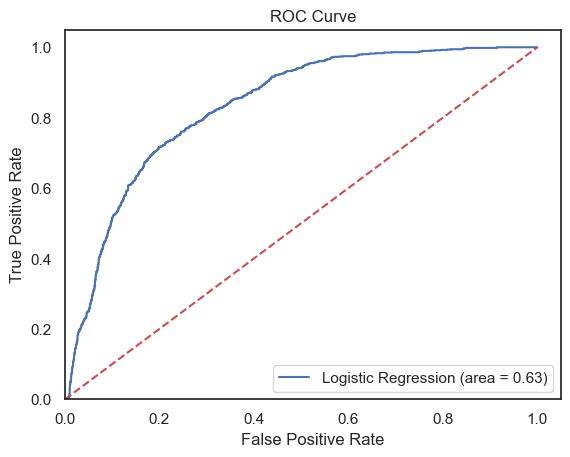

In [48]:
plot_roc(lr, X_test, y_test)

# Feature Construction

In [53]:
hr_fe = hr_ready.copy()

# Bin Satisfaction Level 

In [54]:
bins = [-1, 0.03, 0.29, 0.41, 0.69, 0.92, 1]
labels = ['(0.00, 0.11)','(0.11,0.35)','(0.35,0.46)','(0.46,0.71)','(0.71,0.92)','(0.92,1.00)']
hr_fe['satisfaction_level_bin'] = pd.cut(hr_fe.satisfaction_level, bins, labels=labels)
hr_fe.satisfaction_level_bin.value_counts()

(0.71,0.92)     4765
(0.46,0.71)     4689
(0.35,0.46)     2012
(0.92,1.00)     1362
(0.11,0.35)     1283
(0.00, 0.11)     888
Name: satisfaction_level_bin, dtype: int64

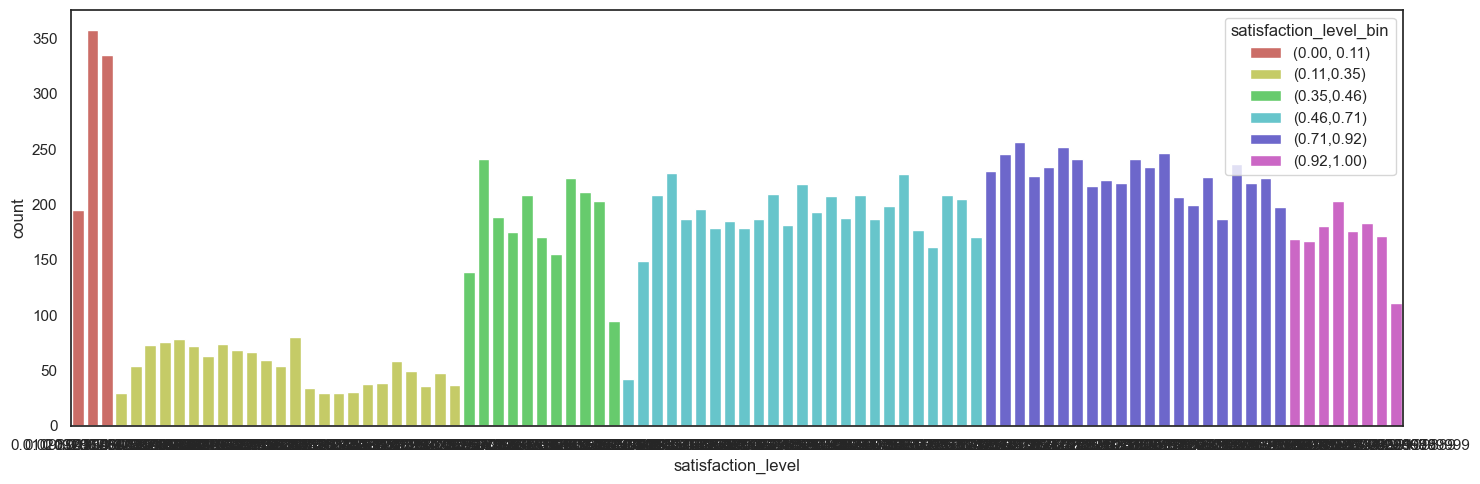

In [55]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe.satisfaction_level,
             hue=hr_fe.satisfaction_level_bin,
             palette = sns.color_palette("hls",6),
             dodge = False)
plt.tight_layout()

In [62]:
# Copy the dataset and perform one-hot encoding
hr_fe_1 = hr_fe.copy()
hr_fe_1 = onehot_encode(hr_fe_1)  # Assuming onehot_encode is a function that encodes categorical variables

# Remove 'satisfaction_level' column
hr_fe_1.drop('satisfaction_level', inplace=True, axis=1)

# Split the dataset into features and labels, and further into training and testing sets
X_fe_1, y_fe_1, X_fe_1_train, X_fe_1_test, y_fe_1_train, y_fe_1_test = split_dataset(hr_fe_1, target, split_ratio, seed)

# Perform 10-fold cross-validation on the logistic regression model
cv_acc(lr, X_fe_1_train, y_fe_1_train, 10, seed)

# Print a newline for separation
print()

# Run the logistic regression on the training and testing data and print results
lr_run(lr, X_fe_1_train, y_fe_1_train, X_fe_1_test, y_fe_1_test)


k-fold cross-validation average accuracy: 0.915
Iteration  1 | Accuracy: 0.91
Iteration  2 | Accuracy: 0.91
Iteration  3 | Accuracy: 0.90
Iteration  4 | Accuracy: 0.91
Iteration  5 | Accuracy: 0.91
Iteration  6 | Accuracy: 0.93
Iteration  7 | Accuracy: 0.92
Iteration  8 | Accuracy: 0.92
Iteration  9 | Accuracy: 0.93
Iteration 10 | Accuracy: 0.92

Accuracy on test: 0.911

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3435
           1       0.83      0.78      0.81      1065

    accuracy                           0.91      4500
   macro avg       0.88      0.87      0.87      4500
weighted avg       0.91      0.91      0.91      4500

Confusion Matrix:
[[3270  165]
 [ 235  830]]

                                Feature     Coef.
0                            intercept. -4.971297
1                       last_evaluation  1.885789
2                  average_montly_hours  1.877144
3                        number_project -0.116467
4  

# Bin Last Evaluation

In [67]:
bins = [-1, 0.14, 0.34, 0.64, 1]
labels = ['(0.00, 0.44)','(0.44,0.57)','(0.57,0.76)','(0.76,1.00)']
hr_fe['last_evaluation_bin'] = pd.cut(hr_fe.last_evaluation, bins, labels=labels)
hr_fe_1['last_evaluation_bin'] = pd.cut(hr_fe_1.last_evaluation, bins, labels=labels)
hr_fe_1.last_evaluation_bin.value_counts()

(0.76,1.00)     6458
(0.57,0.76)     4279
(0.44,0.57)     3817
(0.00, 0.44)     445
Name: last_evaluation_bin, dtype: int64

## plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_1.last_evaluation,
             hue=hr_fe_1.last_evaluation_bin,
             palette = sns.color_palette("hls", 6),
             dodge = False)
plt.tight_layout()

In [65]:
hr_fe_2 = hr_fe.copy()
hr_fe_2 = onehot_encode(hr_fe_2)

hr_fe_2.drop('last_evaluation', inplace=True, axis=1)

X_fe_2, y_fe_2, X_fe_2_train, X_fe_2_test, y_fe_2_train, y_fe_2_test = split_dataset(hr_fe_2, target, split_ratio, seed)

cv_acc(lr, X_fe_2_train, y_fe_2_train, 10, seed)

lr_run(lr, X_fe_2_train, y_fe_2_train, X_fe_2_test, y_fe_2_test)

k-fold cross-validation average accuracy: 0.936
Iteration  1 | Accuracy: 0.94
Iteration  2 | Accuracy: 0.93
Iteration  3 | Accuracy: 0.92
Iteration  4 | Accuracy: 0.93
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.94
Iteration  7 | Accuracy: 0.94
Iteration  8 | Accuracy: 0.94
Iteration  9 | Accuracy: 0.95
Iteration 10 | Accuracy: 0.93
Accuracy on test: 0.936

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3435
           1       0.88      0.84      0.86      1065

    accuracy                           0.94      4500
   macro avg       0.92      0.90      0.91      4500
weighted avg       0.94      0.94      0.94      4500

Confusion Matrix:
[[3316  119]
 [ 170  895]]

                                Feature     Coef.
0                            intercept. -6.115646
1                    satisfaction_level -0.746693
2                  average_montly_hours  2.188308
3                        number_project  0.059042
4   

# Bin Average Monthly Hours

In [68]:
bins = [-1, 0.14, 0.165, 0.304, 0.565, 0.840, 0.897, 1]
labels = ['(0, 125)','(125, 131)','(131, 161)', '(161, 216)','(216, 274)','(274,287)','(287,310)']
hr_fe['average_montly_hours_bin'] = pd.cut(hr_fe.average_montly_hours, bins, labels=labels)
hr_fe_2['average_montly_hours_bin'] = pd.cut(hr_fe_2.average_montly_hours, bins, labels=labels)
hr_fe_2.average_montly_hours_bin.value_counts()

(216, 274)    5573
(161, 216)    4290
(131, 161)    3588
(0, 125)       486
(274,287)      379
(125, 131)     353
(287,310)      330
Name: average_montly_hours_bin, dtype: int64

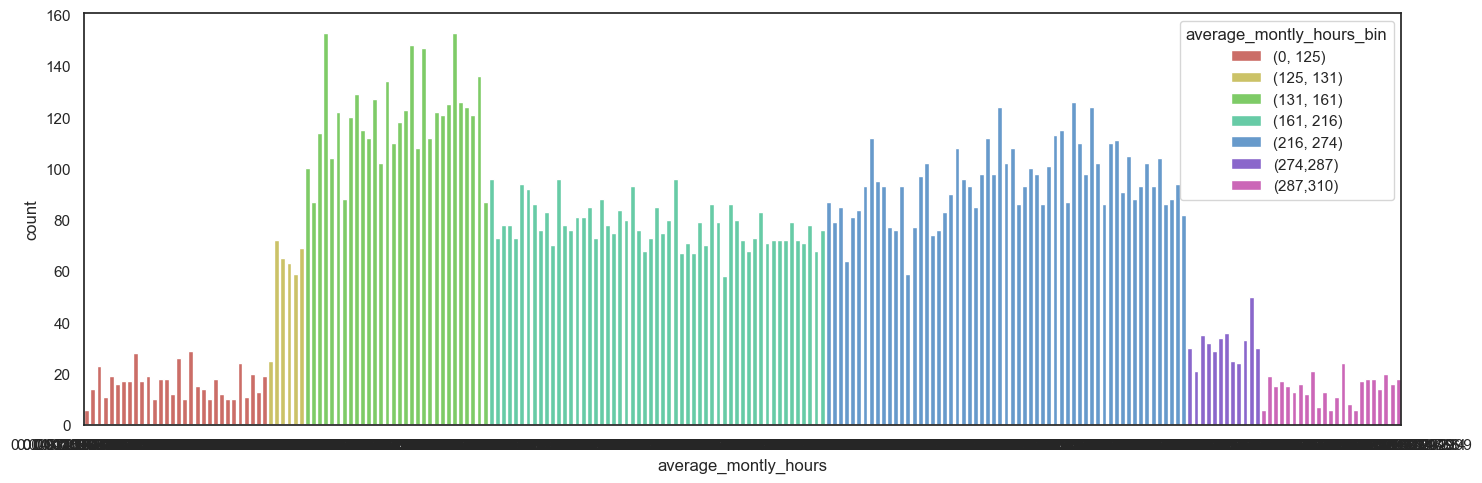

In [69]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_2.average_montly_hours,
             hue=hr_fe_2.average_montly_hours_bin,
             palette = sns.color_palette("hls", 7 ),
             dodge = False)
plt.tight_layout()

In [72]:
hr_fe_3 = hr_fe.copy()
hr_fe_3 = onehot_encode(hr_fe_3)

hr_fe_3.drop('average_montly_hours',inplace=True,axis=1)

X_fe_3, y_fe_3, X_fe_3_train, X_fe_3_test, y_fe_3_train, y_fe_3_test = split_dataset(hr_fe_3, target, split_ratio, seed)

cv_acc(lr, X_fe_3_train, y_fe_3_train, 10, seed)

lr_run(lr, X_fe_3_train, y_fe_3_train, X_fe_3_test, y_fe_3_test)

k-fold cross-validation average accuracy: 0.948
Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.94
Iteration  3 | Accuracy: 0.93
Iteration  4 | Accuracy: 0.95
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.94
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.95
Accuracy on test: 0.950

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3435
           1       0.91      0.88      0.89      1065

    accuracy                           0.95      4500
   macro avg       0.94      0.92      0.93      4500
weighted avg       0.95      0.95      0.95      4500

Confusion Matrix:
[[3343   92]
 [ 132  933]]

                                Feature     Coef.
0                            intercept. -6.474889
1                    satisfaction_level -1.032639
2                       last_evaluation  3.075900
3                        number_project  0.151454
4   

# Categorize number of projects

In [73]:
categ = {2:'too low', 3:'normal', 4:'normal', 5:'normal',6:'too high',7:'extreme'}
hr_fe['number_project_cat'] = hr_fe.number_project.map(categ)
hr_fe_3['number_project_cat'] = hr_fe_3.number_project.map(categ)
hr_fe_3.number_project_cat.value_counts()

normal      11181
too low      2388
too high     1174
extreme       256
Name: number_project_cat, dtype: int64

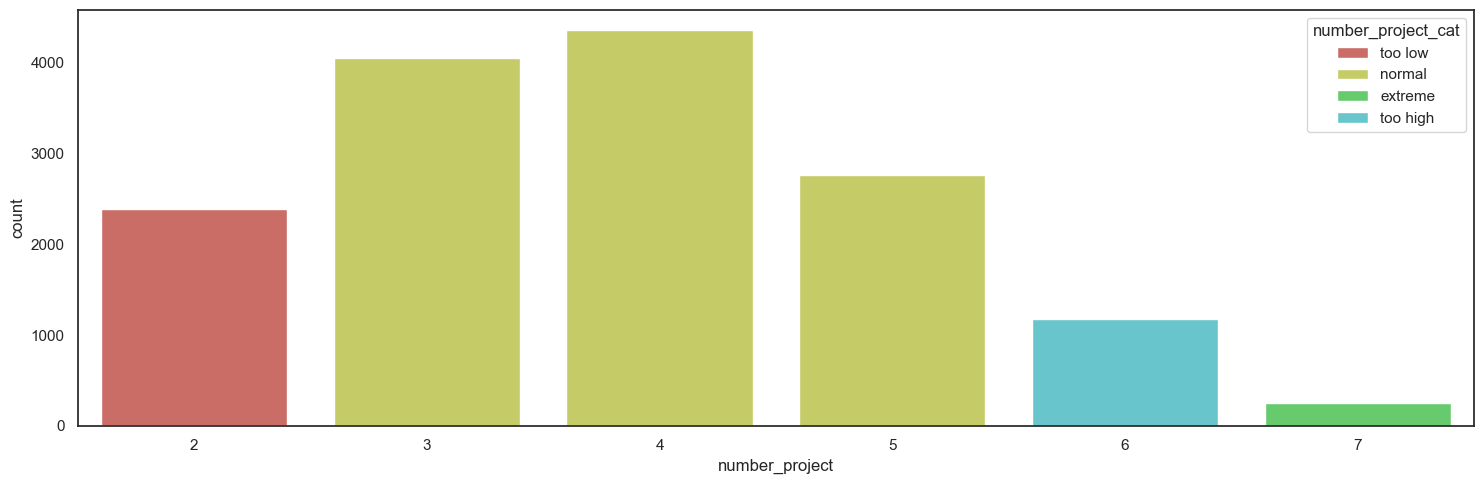

In [74]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_3.number_project,
             hue=hr_fe_3.number_project_cat,
             palette = sns.color_palette("hls",6),
             dodge=False)
plt.tight_layout()

In [75]:
hr_fe_4 = hr_fe.copy()
hr_fe_4 = onehot_encode(hr_fe_3)

hr_fe_4.drop('number_project',inplace=True,axis=1)

X_fe_4, y_fe_4, X_fe_4_train, X_fe_4_test, y_fe_4_train, y_fe_4_test = split_dataset(hr_fe_4, target, split_ratio, seed)

cv_acc(lr, X_fe_4_train, y_fe_4_train, 10, seed)

lr_run(lr, X_fe_4_train, y_fe_4_train, X_fe_4_test, y_fe_4_test)

k-fold cross-validation average accuracy: 0.949
Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.95
Iteration  3 | Accuracy: 0.93
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.94
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.95
Iteration  9 | Accuracy: 0.95
Iteration 10 | Accuracy: 0.95
Accuracy on test: 0.950

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3435
           1       0.90      0.88      0.89      1065

    accuracy                           0.95      4500
   macro avg       0.93      0.93      0.93      4500
weighted avg       0.95      0.95      0.95      4500

Confusion Matrix:
[[3336   99]
 [ 125  940]]

                                Feature     Coef.
0                            intercept. -4.403433
1                    satisfaction_level -1.209856
2                       last_evaluation  3.126538
3                    time_spend_company  0.500419
4   

# Categorize time spent in company

In [79]:
categ = {2:'low departure', 3:'high departure', 4:'high departure', 5:'very high departure', 6:'high departure', 7:'no departure', 8:'no departure', 10:'no departure'}
hr_fe['time_spend_company_cat'] = hr_fe.time_spend_company.map(categ)
hr_fe_4['time_spend_company_cat'] = hr_fe_4.time_spend_company.map(categ)
hr_fe_4.time_spend_company_cat.value_counts()

high departure         9718
low departure          3244
very high departure    1473
no departure            564
Name: time_spend_company_cat, dtype: int64

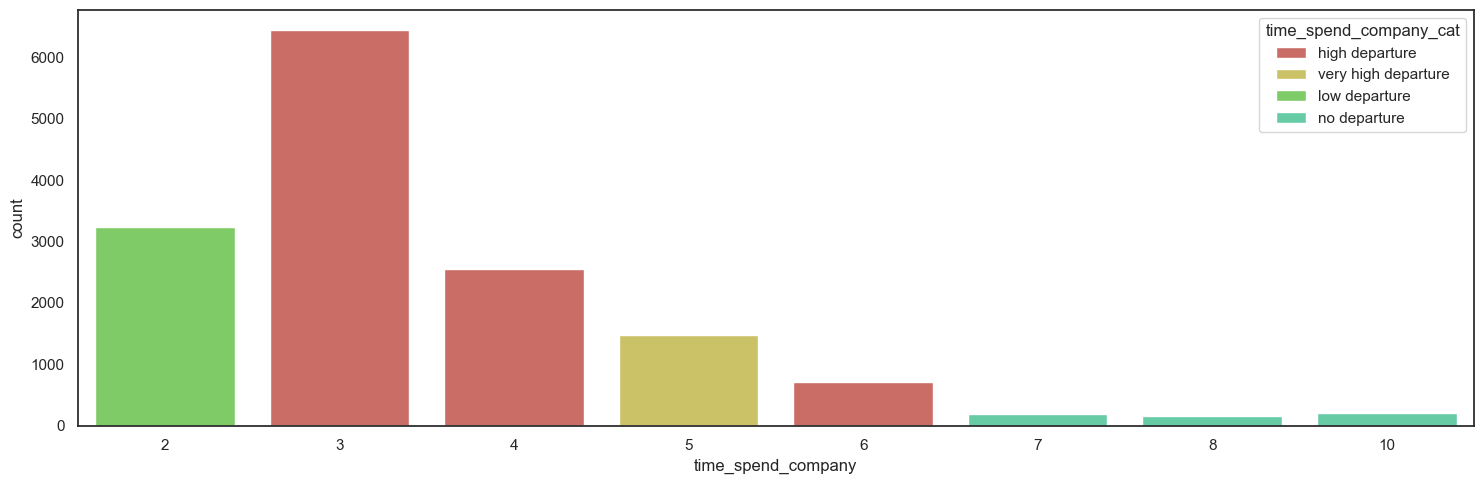

In [80]:
plt.figure(figsize=(15,5))
sns.countplot(x=hr_fe_4.time_spend_company,
              hue=hr_fe_4.time_spend_company_cat,
              palette = sns.color_palette("hls", 7),
              dodge = False)
plt.tight_layout()

In [83]:
hr_fe_5 = hr_fe.copy()
hr_fe_5 = onehot_encode(hr_fe_5)

hr_fe_5.drop('time_spend_company',inplace=True,axis=1)

X_fe_5, y_fe_5, X_fe_5_train, X_fe_5_test, y_fe_5_train, y_fe_5_test = split_dataset(hr_fe_5, target, split_ratio, seed)

cv_acc(lr, X_fe_5_train, y_fe_5_train, 10, seed)

lr_run(lr, X_fe_5_train, y_fe_5_train, X_fe_5_test, y_fe_5_test)

k-fold cross-validation average accuracy: 0.959
Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.96
Iteration  3 | Accuracy: 0.96
Iteration  4 | Accuracy: 0.97
Iteration  5 | Accuracy: 0.96
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.96
Iteration 10 | Accuracy: 0.96
Accuracy on test: 0.958

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3435
           1       0.92      0.90      0.91      1065

    accuracy                           0.96      4500
   macro avg       0.95      0.94      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3354   81]
 [ 110  955]]

                                       Feature     Coef.
0                                   intercept. -6.969732
1                           satisfaction_level -1.273590
2                              last_evaluation  2.527626
3                         

# Removing Unbinned variables and Encoding New features 

In [85]:
hr_fe_encoded = onehot_encode(hr_fe)
hr_fe_encoded.drop('satisfaction_level', inplace=True, axis=1)
hr_fe_encoded.drop('last_evaluation', inplace=True, axis=1)
hr_fe_encoded.drop('average_montly_hours', inplace=True, axis=1)
hr_fe_encoded.drop('number_project', inplace=True, axis=1)
hr_fe_encoded.drop('time_spend_company', inplace=True, axis=1)
df_desc(hr_fe_encoded)

,dtype,NAs,Numerical,Boolean,Categorical
Work_accident,int64,0,False,True,False
left,int64,0,False,True,False
promotion_last_5years,int64,0,False,True,False
salary_high,uint8,0,False,True,False
salary_low,uint8,0,False,True,False
salary_medium,uint8,0,False,True,False
department_IT,uint8,0,False,True,False
department_RandD,uint8,0,False,True,False
department_accounting,uint8,0,False,True,False
department_hr,uint8,0,False,True,False


In [86]:
X_fe_encoded, y_fe_encoded, X_fe_encoded_train, X_fe_encoded_test, y_fe_encoded_train, y_fe_encoded_test = split_dataset(hr_fe_encoded, target, split_ratio, seed)
cv_acc(lr, X_fe_encoded_train, y_fe_encoded_train, 10, seed)
print()
lr_run(lr, X_fe_encoded_train, y_fe_encoded_train, X_fe_encoded_test, y_fe_encoded_test)


k-fold cross-validation average accuracy: 0.956
Iteration  1 | Accuracy: 0.95
Iteration  2 | Accuracy: 0.96
Iteration  3 | Accuracy: 0.95
Iteration  4 | Accuracy: 0.96
Iteration  5 | Accuracy: 0.95
Iteration  6 | Accuracy: 0.96
Iteration  7 | Accuracy: 0.96
Iteration  8 | Accuracy: 0.96
Iteration  9 | Accuracy: 0.95
Iteration 10 | Accuracy: 0.96

Accuracy on test: 0.957

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3435
           1       0.93      0.88      0.91      1065

    accuracy                           0.96      4500
   macro avg       0.95      0.93      0.94      4500
weighted avg       0.96      0.96      0.96      4500

Confusion Matrix:
[[3363   72]
 [ 123  942]]

                                       Feature     Coef.
0                                   intercept. -2.063514
1                                Work_accident -1.227837
2                        promotion_last_5years -0.481205
3                        

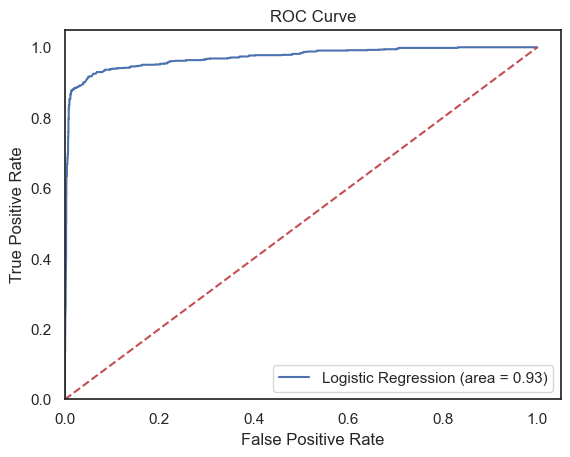

In [87]:
plot_roc(lr, X_fe_encoded_test, y_fe_encoded_test)

# Thank You